#  Optimizing Edge Server Placement Using Hybrid Metaheuristic Algorithms  
*A Comprehensive Framework for Edge Computing Infrastructure Optimization*  

---

## **Project Overview**  
This research implements and evaluates **10+ metaheuristic algorithms** for solving the **Edge Server Placement (ESP)** problem in next-generation computing infrastructures. The framework provides:  
- Realistic edge-cloud system modeling with queuing dynamics  
- Novel algorithm hybrids (PSO-WAO, TLBO-WOA)  
- Rigorous scalability, sensitivity, and convergence analysis  
- Statistical validation of algorithm performance  

**Core Objective:**  
Minimize average response time through optimal server placement:  


---

## **Key Components**  
### 1. Problem Modeling  
- **Base station-server assignment** with capacity constraints  
- **M/M/1 queuing** with cloud offloading  
- **Request-weighted latency minimization**  

### 2. Algorithm Portfolio  
| Algorithm      | Type                  | Key Mechanism                     |
|----------------|-----------------------|-----------------------------------|
| GA             | Evolutionary          | Selection-Crossover-Mutation     |
| PSO            | Swarm Intelligence    | Velocity-position updates        |
| WOA            | Nature-inspired       | Bubble-net hunting               |
| GWO            | Metaheuristic         | Wolf pack hierarchy              |
| **TLBO-WOA**   | **Novel Hybrid**      | Teaching-learning + Whale optimization |

### 3. Experimental Framework  
- **Scale analysis** (100-1000 servers)  
- **Load sensitivity** (0.1-0.9 traffic intensity)  
- **Convergence behavior** visualization  
- **Statistical significance** testing  

---

## **Research Innovations**  
1. **Hybrid Algorithm Development**:  
   - `PSO-WAO`: Combines particle swarm exploration with whale exploitation  
   - `TLBO-WOA`: Integrates teaching-learning with whale hunting strategies  

2. **Mathematical Foundations**:  
   - Lévy flights for efficient global exploration  
   - Queuing-theoretic fitness evaluation  
   - Vectorized capacity-delay computation  

3. **Analytical Advancements**:  
   - Cohen's d effect size quantification  
   - Radar chart multi-metric assessment  
   - Swarmplot-boxplot hybrid visualizations  

## **Authors**
   - Muhammad Suliman
   - Ali Hamza

---


### **Install Dependencies and Import Libraries**

In [ ]:
!pip install scikit-learn seaborn --quiet
!pip install pandas
!pip install joblib --quiet


import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from time import time
import copy
from joblib import Parallel, delayed


### **Configure Plotting Settings**

In [ ]:
plt.style.use('default')
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'figure.figsize': (8, 4),
    'font.size': 10,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'grid.alpha': 0.3,
    'lines.linewidth': 1.5,
    'lines.markersize': 6
})

### **EdgeFitness Class**  
**Purpose:**  
The `EdgeFitness` class implements the core queuing model for evaluating edge server placement solutions. It calculates the average response time experienced by user requests in an edge-cloud environment, serving as the optimization objective function for all algorithms.

**Key Features:**  
1. **Vectorized Computation**:  
   - Utilizes NumPy vector operations for efficient fitness evaluation  
   - Processes entire solutions in parallel rather than element-wise  
   - Optimized for performance with large-scale problems  

2. **Robust Validation**:  
   - Automatic solution flattening to 1D arrays  
   - Dimension compatibility checks between solution and system parameters  
   - Clip-based index validation to prevent out-of-bound errors  

3. **Queuing Model**:  
   - Models base stations as M/M/1 queues  
   - Implements cloud offloading with fixed delay  
   - Calculates system-wide weighted average response time  

**Mathematical Model:**  
1. **Server Allocation**:  
   $$\text{valid\_indices} = \text{clip}(\text{solution}, 0, N_{\text{bs}}-1)$$  
   $$\text{edge\_capacity}_j = \sum_{i:\ \text{solution}[i]=j} \mu_i \ \forall j \in [0, N_{\text{bs}}-1]$$  

2. **Capacity Validation**:  
   $$\text{valid\_capacity}_j = \begin{cases}
   \text{edge\_capacity}_j - \lambda_j & \text{if } >0 \\
   \infty & \text{otherwise}
   \end{cases}$$  

3. **Delay Calculation**:  
   $$\text{edge\_delays}_j = \frac{1}{\text{valid\_capacity}_j}$$  
   $$\text{final\_delays}_j = \min(\text{edge\_delays}_j, D_{\text{cloud}})$$  

4. **Fitness Metric**:  


  Where:  
  - $\lambda_j$ = Request rate at base station $j$  
  - $\text{final\_delays}_j$ = Minimum delay for requests at base station $j$  
  - $\sum \lambda$ = Total system request rate ($\sum_{j=0}^{N_{\text{bs}}-1} \lambda_j$)  


In [ ]:
class EdgeFitness:
    def __init__(self, srv_rate, req_rate, cloud_delay):
        self.srv_rate = np.asarray(srv_rate).flatten()
        self.req_rate = np.asarray(req_rate).flatten()
        self.cloud_delay = cloud_delay
        self.num_srv = len(self.srv_rate)
        self.num_bs = len(self.req_rate)
        self.total_requests = self.req_rate.sum()

    def calculate(self, solution):
        """Vectorized fitness calculation with enhanced validation"""
        solution = np.asarray(solution).flatten()
        if len(solution) != self.num_srv:
            raise ValueError(
                f"Solution shape {solution.shape} incompatible. "
                f"Expected {self.num_srv} servers, got {len(solution)}"
            )

        assert self.srv_rate.ndim == 1, "srv_rate must be 1D"
        assert self.req_rate.ndim == 1, "req_rate must be 1D"
        assert len(self.srv_rate) == self.num_srv, "srv_rate length mismatch"
        assert len(self.req_rate) == self.num_bs, "req_rate length mismatch"

        valid_indices = np.clip(solution, 0, self.num_bs-1).astype(int)
        edge_capacity = np.zeros(self.num_bs, dtype=np.float32)
        np.add.at(edge_capacity, valid_indices, self.srv_rate)

        valid_capacity = edge_capacity - self.req_rate
        valid_capacity = np.where(valid_capacity <= 0, np.inf, valid_capacity)
        edge_delays = 1 / valid_capacity

        final_delays = np.minimum(edge_delays, self.cloud_delay)
        return np.dot(final_delays, self.req_rate) / self.total_requests

### **Genetic Algorithm Implementation for Edge Server Placement**
**Description:**

This implements a canonical Genetic Algorithm (GA) to solve the Edge Server Placement (ESP) optimization problem. The GA evolves a population of candidate solutions through selection, crossover, and mutation operations to minimize the average response time calculated by the fitness function. Key features include tournament selection for parent selection, uniform crossover for recombination, and random mutation to maintain population diversity. The algorithm employs elitism to preserve the best solutions across generations and tracks convergence history for performance analysis.

**Mathematical Foundation:**

The GA operates on the principle of natural selection, where solutions are represented as chromosomes (server placement vectors). The fitness function evaluates each solution using queuing theory models (M/M/1 queues with cloud offloading). The evolutionary process follows:

Selection pressure via tournament selection

Genetic recombination through probabilistic crossover

Diversity maintenance via random mutations

Elitist survival strategy

In [ ]:
class GeneticOptimizer:
    def __init__(self, fitness_fn, num_pop=30, dim=20, cross_prob=0.8, mut_prob=0.1, max_iter=30,
                 tournament_size=4, elitism_ratio=0.1):
        self.fitness = fitness_fn
        self.num_pop = num_pop
        self.dim = dim
        self.cross_prob = cross_prob
        self.mut_prob = mut_prob
        self.max_iter = max_iter
        self.tournament_size = tournament_size
        self.elitism_ratio = elitism_ratio
        self.history = []

    def initialize(self, low, high):
        return np.random.randint(low, high, size=(self.num_pop, self.dim))

    def crossover(self, parent1, parent2):
        """Two-point crossover for better exploration"""
        if np.random.rand() > self.cross_prob:
            return parent1.copy()

        pt1, pt2 = sorted(np.random.choice(self.dim, 2, replace=False))
        child = np.concatenate([
            parent1[:pt1],
            parent2[pt1:pt2],
            parent1[pt2:]
        ])
        return child

    def mutate(self, individual, low, high):
        """Gene-wise mutation with probability control"""
        mask = np.random.rand(self.dim) < self.mut_prob

        if np.any(mask):
            mutated = individual.copy()
            mutated[mask] = np.random.randint(low, high, size=np.sum(mask))
            return mutated
        return individual

    def optimize(self, low=0, high=1):
        pop = self.initialize(low, high)
        fitness = np.array(Parallel(n_jobs=-1)(
            delayed(self.fitness.calculate)(ind) for ind in pop
        ))

        best_idx = np.argmin(fitness)
        best_solution = pop[best_idx].copy()
        best_fitness = fitness[best_idx]
        self.history = [best_fitness]
        no_improve = 0

        num_elites = max(1, int(self.num_pop * self.elitism_ratio))

        for _ in range(self.max_iter):
            # Tournament selection
            selected = []
            for _ in range(self.num_pop):
                contenders = np.random.choice(self.num_pop, self.tournament_size, replace=False)
                winner = contenders[np.argmin(fitness[contenders])]
                selected.append(pop[winner])

            # Crossover - produce offspring
            offspring = []
            for i in range(0, self.num_pop, 2):
                if i+1 < self.num_pop:
                    child1 = self.crossover(selected[i], selected[i+1])
                    child2 = self.crossover(selected[i+1], selected[i])
                    offspring.extend([child1, child2])
                else:
                    offspring.append(selected[i].copy())

            # Mutation
            offspring = [self.mutate(ind, low, high) for ind in offspring]
            offspring_fitness = np.array(Parallel(n_jobs=-1)(
                delayed(self.fitness.calculate)(ind) for ind in offspring
            ))

            # Combine populations
            combined = np.vstack([pop, offspring])
            combined_fitness = np.hstack([fitness, offspring_fitness])

            # Elitism: preserve top individuals
            elite_indices = np.argsort(fitness)[:num_elites]
            elites = pop[elite_indices]
            elite_fitness = fitness[elite_indices]

            non_elite = np.delete(combined, elite_indices, axis=0)
            non_elite_fitness = np.delete(combined_fitness, elite_indices)

            best_indices = np.argsort(non_elite_fitness)[:self.num_pop - num_elites]
            pop = np.vstack([elites, non_elite[best_indices]])
            fitness = np.hstack([elite_fitness, non_elite_fitness[best_indices]])

            # Update best solution
            current_best = np.min(fitness)
            if current_best < best_fitness:
                best_fitness = current_best
                best_solution = pop[np.argmin(fitness)].copy()
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= 5:
                break

            self.history.append(best_fitness)

        return best_solution, best_fitness, self.history

### **Particle Swarm Optimization for Edge Server Placement**
**Description:**

This implements a Particle Swarm Optimization (PSO) algorithm to solve the Edge Server Placement problem. The PSO simulates the social behavior of bird flocking or fish schooling, where particles (solutions) move through the search space while being influenced by their personal best positions and the global best position found by the swarm. The algorithm is particularly effective for continuous optimization problems but has been adapted here for discrete server placement through position discretization.

**Key Features:**

Particles represent potential server placement configurations

Social learning through global best attraction

Cognitive learning through personal best attraction

Linearly decreasing inertia weight for balanced exploration/exploitation

Velocity clamping and position discretization for integer solutions

**Mathematical Formulation:**

\begin{align*}
v_{t+1} &= w \cdot v_t + c_1 r_1 (pbest_t - x_t) + c_2 r_2 (gbest_t - x_t) \\
x_{t+1} &= x_t + v_{t+1}
\end{align*}



In [ ]:
class SwarmOptimizer:
    def __init__(self, fitness_fn, num_pop=30, dim=20,
                 w_range=(0.4, 1.2), c1=2.0, c2=2.0, max_iter=30):
        self.fitness = fitness_fn
        self.num_pop = num_pop
        self.dim = dim
        self.w_start, self.w_end = w_range
        self.c1 = c1
        self.c2 = c2
        self.max_iter = max_iter
        self.history = []
        self.vel_scale = 0.2

    def optimize(self, low=0, high=1):
        positions = np.random.randint(low, high, size=(self.num_pop, self.dim))
        velocities = np.random.uniform(-1, 1, size=(self.num_pop, self.dim))

        personal_best = positions.copy()
        personal_fitness = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind) for ind in positions))

        global_best_idx = np.argmin(personal_fitness)
        global_best = positions[global_best_idx].copy()
        global_fitness = personal_fitness[global_best_idx]
        self.history = [global_fitness]
        w = self.w_start
        dw = (self.w_start - self.w_end) / self.max_iter
        no_improve = 0

        for _ in range(self.max_iter):
            r1 = np.random.rand(self.num_pop, self.dim)
            r2 = np.random.rand(self.num_pop, self.dim)

            velocities = w * velocities + self.c1 * r1 * (personal_best - positions) + self.c2 * r2 * (global_best - positions)
            positions = np.clip(positions + (self.vel_scale * velocities).astype(int), low, high-1)

            current_fitness = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind) for ind in positions))

            improved = current_fitness < personal_fitness
            personal_best[improved] = positions[improved]
            personal_fitness[improved] = current_fitness[improved]

            if np.min(current_fitness) < global_fitness:
                global_fitness = np.min(current_fitness)
                global_best = positions[np.argmin(current_fitness)].copy()
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= 5:
                break

            self.history.append(global_fitness)
            w -= dw

        return global_best, global_fitness, self.history

### **Whale Optimization Algorithm (WOA)**

**Description:**  
Implements the Whale Optimization Algorithm inspired by humpback whales' bubble-net hunting strategy. Simulates encircling prey, spiral bubble-net feeding, and random prey search to balance exploration and exploitation. Progressively refines solutions by adaptively switching between behaviors to minimize response time.

**Mathematical Foundation:**  
1. **Encircling Prey**:  
   $\vec{D} = |\vec{C} \cdot \vec{X}^*(t) - \vec{X}(t)|$  
   $\vec{X}(t+1) = \vec{X}^*(t) - \vec{A} \cdot \vec{D}$  
2. **Bubble-net Attack**:  
   $\vec{X}(t+1) = \vec{D}' \cdot e^{bl} \cdot \cos(2\pi l) + \vec{X}^*(t)$  
3. **Prey Search**:  
   $\vec{D} = |\vec{C} \cdot \vec{X}_{\text{rand}} - \vec{X}|$  
   $\vec{X}(t+1) = \vec{X}_{\text{rand}} - \vec{A} \cdot \vec{D}$  
where $\vec{A} = 2\vec{a}\vec{r} - \vec{a}$, $\vec{C} = 2\vec{r}$, $l \in [-1,1]$, $\vec{a}$ decreases linearly.

In [ ]:
class WhaleOptimizer:
    def __init__(self, fitness_fn, num_pop=30, dim=20, max_iter=30):
        self.fitness = fitness_fn
        self.num_pop = num_pop
        self.dim = dim
        self.max_iter = max_iter
        self.history = []

    def optimize(self, low=0, high=1):
        positions = np.random.randint(low, high, size=(self.num_pop, self.dim))
        fitness = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind) for ind in positions))

        best_idx = np.argmin(fitness)
        best_solution = positions[best_idx].copy()
        best_fitness = fitness[best_idx]
        self.history = [best_fitness]
        no_improve = 0

        for iter in range(self.max_iter):
            a = 2 - 2 * iter / self.max_iter
            a2 = -1 + iter * (-1 / self.max_iter)

            new_positions = []
            for i in range(self.num_pop):
                if np.random.rand() < 0.5:
                    # Encircling prey
                    A = 2 * a * np.random.rand() - a
                    C = 2 * np.random.rand()
                    D = np.abs(C * best_solution - positions[i])
                    new_pos = (best_solution - A * D).astype(int)
                else:
                    # Spiral update
                    D = np.abs(best_solution - positions[i])
                    l = np.random.uniform(-1, 1)
                    new_pos = (D * np.exp(a2 * l) * np.cos(2*np.pi*l) + best_solution).astype(int)

                new_pos = np.clip(new_pos, low, high-1)
                new_positions.append(new_pos)

            new_positions = np.array(new_positions)
            new_fitness = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind) for ind in new_positions))

            improved = new_fitness < fitness
            positions[improved] = new_positions[improved]
            fitness[improved] = new_fitness[improved]

            current_best = np.min(fitness)
            if current_best < best_fitness:
                best_fitness = current_best
                best_solution = positions[np.argmin(fitness)].copy()
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= 5:
                break

            self.history.append(best_fitness)

        return best_solution, best_fitness, self.history

### **Grey Wolf Optimizer (GWO) Implementation**  
**Description:**  
Mimics grey wolf pack hierarchy and hunting tactics. Alpha, beta, and delta wolves guide omega wolves toward promising regions. Hierarchical collaboration enables efficient exploration while social hierarchy drives exploitation.

**Mathematical Foundation:**  
$$\vec{D}_\alpha = |\vec{C}_1 \cdot \vec{X}_\alpha - \vec{X}|, \ \ \vec{D}_\beta = |\vec{C}_2 \cdot \vec{X}_\beta - \vec{X}|, \ \ \vec{D}_\delta = |\vec{C}_3 \cdot \vec{X}_\delta - \vec{X}|$$  
$$\vec{X}_1 = \vec{X}_\alpha - \vec{A}_1 \cdot \vec{D}_\alpha, \ \ \vec{X}_2 = \vec{X}_\beta - \vec{A}_2 \cdot \vec{D}_\beta, \ \ \vec{X}_3 = \vec{X}_\delta - \vec{A}_3 \cdot \vec{D}_\delta$$  
$$\vec{X}(t+1) = \frac{\vec{X}_1 + \vec{X}_2 + \vec{X}_3}{3}$$  
where $\vec{A} = 2\vec{a}\vec{r}_1 - \vec{a}$ decreases from 2→0.

In [ ]:
class GreyWolfOptimizer:
    def __init__(self, fitness_fn, num_pop=30, dim=20, max_iter=30):
        self.fitness = fitness_fn
        self.num_pop = num_pop
        self.dim = dim
        self.max_iter = max_iter
        self.history = []

    def optimize(self, low=0, high=1):
        positions = np.random.randint(low, high, size=(self.num_pop, self.dim))
        fitness = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind) for ind in positions))

        sorted_idx = np.argsort(fitness)
        alpha = positions[sorted_idx[0]].copy()
        beta = positions[sorted_idx[1]].copy()
        delta = positions[sorted_idx[2]].copy()

        best_fitness = fitness[sorted_idx[0]]
        best_solution = alpha.copy()
        self.history = [best_fitness]
        no_improve = 0

        for iter in range(self.max_iter):
            a = 2 - 2 * iter / self.max_iter
            new_positions = []

            for i in range(self.num_pop):
                X1 = np.zeros(self.dim)
                X2 = np.zeros(self.dim)
                X3 = np.zeros(self.dim)

                for d in range(self.dim):
                    # Alpha
                    A1 = 2 * a * np.random.rand() - a
                    C1 = 2 * np.random.rand()
                    D_alpha = abs(C1 * alpha[d] - positions[i,d])
                    X1[d] = alpha[d] - A1 * D_alpha

                    # Beta
                    A2 = 2 * a * np.random.rand() - a
                    C2 = 2 * np.random.rand()
                    D_beta = abs(C2 * beta[d] - positions[i,d])
                    X2[d] = beta[d] - A2 * D_beta

                    # Delta
                    A3 = 2 * a * np.random.rand() - a
                    C3 = 2 * np.random.rand()
                    D_delta = abs(C3 * delta[d] - positions[i,d])
                    X3[d] = delta[d] - A3 * D_delta

                    new_dim = (X1[d] + X2[d] + X3[d]) / 3
                    new_positions.append(int(np.clip(new_dim, low, high-1)))

            new_positions = np.array(new_positions).reshape(self.num_pop, self.dim)
            new_fitness = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind) for ind in new_positions))

            improved = new_fitness < fitness
            positions[improved] = new_positions[improved]
            fitness[improved] = new_fitness[improved]

            sorted_idx = np.argsort(fitness)
            alpha = positions[sorted_idx[0]].copy()
            beta = positions[sorted_idx[1]].copy()
            delta = positions[sorted_idx[2]].copy()

            current_best = fitness[sorted_idx[0]]
            if current_best < best_fitness:
                best_fitness = current_best
                best_solution = alpha.copy()
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= 5:
                break

            self.history.append(best_fitness)

        return best_solution, best_fitness, self.history




### **Artificial Bee Colony (ABC) Implementation**  
**Description:**  
Models honey bee foraging with employed bees (exploitation), onlooker bees (selection), and scout bees (exploration). Balances solution refinement and discovery through waggle dance-inspired information sharing.

**Mathematical Foundation:**  
1. **Employed Bee Phase**:  
   $v_{ij} = x_{ij} + \phi_{ij}(x_{ij} - x_{kj})$  
2. **Onlooker Phase** (Roulette selection):  
   $P_i = \frac{\text{fitness}_i}{\sum \text{fitness}_i}$  
3. **Scout Phase**:  
   $\vec{x}_i = \vec{x}_{\text{min}} + \text{rand}(0,1) \cdot (\vec{x}_{\text{max}} - \vec{x}_{\text{min}})$  
Solutions exceeding 'limit' trials are abandoned.

In [ ]:
class BeeColonyOptimizer:
    def __init__(self, fitness_fn, num_pop=30, dim=20, max_iter=30, limit=50):
        self.fitness = fitness_fn
        self.num_pop = num_pop
        self.dim = dim
        self.max_iter = max_iter
        self.limit = limit
        self.history = []

    def optimize(self, low=0, high=1):
        population = np.random.randint(low, high, size=(self.num_pop, self.dim))
        fitness = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind) for ind in population))
        trials = np.zeros(self.num_pop)

        best_idx = np.argmin(fitness)
        best_solution = population[best_idx].copy()
        best_fitness = fitness[best_idx]
        self.history = [best_fitness]
        no_improve = 0

        for _ in range(self.max_iter):
            # Employed bees
            new_positions = []
            for i in range(self.num_pop):
                partner = np.random.choice(self.num_pop)
                while partner == i:
                    partner = np.random.choice(self.num_pop)

                phi = np.random.uniform(-1, 1, self.dim)
                new_pos = np.clip(population[i] + phi * (population[i] - population[partner]), low, high-1).astype(int)
                new_positions.append(new_pos)

            new_positions = np.array(new_positions)
            new_fitness = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind) for ind in new_positions))

            improved = new_fitness < fitness
            population[improved] = new_positions[improved]
            fitness[improved] = new_fitness[improved]
            trials[~improved] += 1

            # Onlooker bees
            probs = (fitness.max() - fitness) / (fitness.max() - fitness.min() + 1e-8)
            probs /= probs.sum()

            selected_indices = np.random.choice(self.num_pop, size=self.num_pop, p=probs)
            onlooker_positions = []
            for idx in selected_indices:
                partner = np.random.choice(self.num_pop)
                phi = np.random.uniform(-1, 1, self.dim)
                new_pos = np.clip(population[idx] + phi * (population[idx] - population[partner]), low, high-1).astype(int)
                onlooker_positions.append(new_pos)

            onlooker_positions = np.array(onlooker_positions)
            onlooker_fitness = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind) for ind in onlooker_positions))

            improved = onlooker_fitness < fitness[selected_indices]
            population[selected_indices[improved]] = onlooker_positions[improved]
            fitness[selected_indices[improved]] = onlooker_fitness[improved]
            trials[selected_indices[~improved]] += 1

            # Scout bees
            for i in range(self.num_pop):
                if trials[i] > self.limit:
                    population[i] = np.random.randint(low, high, self.dim)
                    fitness[i] = self.fitness.calculate(population[i])
                    trials[i] = 0

            # Update best
            current_best = np.min(fitness)
            if current_best < best_fitness:
                best_fitness = current_best
                best_solution = population[np.argmin(fitness)].copy()
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= 5:
                break

            self.history.append(best_fitness)

        return best_solution, best_fitness, self.history

### **Hybrid GP4ESP Algorithm Implementation**
**Description:**

This implements the hybrid Genetic Algorithm (GA) + Particle Swarm Optimization (PSO) approach (GP4ESP) for Edge Server Placement optimization. The algorithm combines:

GA's evolutionary operators (crossover & mutation)

PSO's social-cognitive learning (personal & global best attraction)

**Key Innovations:**

Triple Crossover Strategy:

Random Partner: Maintains population diversity

Personal Best (Self-Cognition): Exploits local optima

Global Best (Social-Cognition): Guides toward swarm consensus

**Adaptive Selection:**

Only accepts mutations that improve fitness

Preserves elites via combined population sorting

**Hybrid Convergence:**

Tracks both GA-style population fitness and PSO-style personal/global bests

History logging enables performance analysis

**Mathematical Formulation:**

*For each particle/solution:
offspring₁ = crossover(current, random_solution)  
offspring₂ = crossover(current, personal_best)  
offspring₃ = crossover(current, global_best)  
best_offspring = min_fitness(offspring₁, offspring₂, offspring₃)  
mutated = mutate(best_offspring)*

In [ ]:
class HybridOptimizer(GeneticOptimizer):
    def __init__(self, fitness_fn, num_pop=30, dim=20, cross_prob=0.8, mut_prob=0.1, max_iter=30):
        super().__init__(
            fitness_fn=fitness_fn,
            num_pop=num_pop,
            dim=dim,
            cross_prob=cross_prob,
            mut_prob=mut_prob,
            max_iter=max_iter
        )
        self.personal_best = None
        self.personal_fitness = None
        self.global_best = None
        self.global_fitness = float('inf')
        self.w = 0.7

    def _ga_crossover(self, parent1, parent2):
        """Uniform crossover with probability check"""
        if random.random() < self.cross_prob:
            mask = np.random.rand(self.dim) < 0.5
            child = np.where(mask, parent1, parent2)
            return child
        return parent1.copy()

    def _pb_crossover(self, parent, personal_best):
        """PSO-inspired crossover with personal best"""
        r = np.random.rand(self.dim)
        return parent + r * (personal_best - parent)

    def _gb_crossover(self, parent, global_best):
        """PSO-inspired crossover with global best"""
        r = np.random.rand(self.dim)
        return parent + r * (global_best - parent)

    def _mutate(self, individual, low, high):
        """Precise single-gene mutation per paper specs"""
        if random.random() < self.mut_prob:
            idx = random.randint(0, self.dim-1)
            individual[idx] = random.uniform(low, high)
        return individual

    def optimize(self, low=0, high=1):
        pop = self.initialize(low, high)
        self.personal_best = pop.copy()
        self.personal_fitness = np.array(Parallel(n_jobs=-1)(
            delayed(self.fitness.calculate)(ind) for ind in pop
        ))

        best_idx = np.argmin(self.personal_fitness)
        self.global_best = pop[best_idx].copy()
        self.global_fitness = self.personal_fitness[best_idx]
        self.history = [self.global_fitness]
        no_improve = 0

        for _ in range(self.max_iter):
            new_pop = []
            new_fitness = []
            offspring_batch = []

            # Generate 6 offspring per individual
            for i in range(self.num_pop):
                # GA crossovers (2 children)
                partner_idx = np.random.randint(0, self.num_pop)
                partner = pop[partner_idx]
                offspring_batch.append(self._ga_crossover(pop[i], partner))
                offspring_batch.append(self._ga_crossover(pop[i], partner))

                # Personal best crossovers (2 children)
                offspring_batch.append(self._pb_crossover(pop[i], self.personal_best[i]))
                offspring_batch.append(self._pb_crossover(pop[i], self.personal_best[i]))

                # Global best crossovers (2 children)
                offspring_batch.append(self._gb_crossover(pop[i], self.global_best))
                offspring_batch.append(self._gb_crossover(pop[i], self.global_best))

            # Parallel evaluation of all offspring
            offspring_fitness = np.array(Parallel(n_jobs=-1)(
                delayed(self.fitness.calculate)(ind) for ind in offspring_batch
            ))

            # Process each individual's offspring
            for i in range(self.num_pop):
                start_idx = i * 6
                end_idx = start_idx + 6
                candidates = offspring_batch[start_idx:end_idx]
                fitnesses = offspring_fitness[start_idx:end_idx]

                best_idx = np.argmin(fitnesses)
                best_offspring = candidates[best_idx]

                mutated = self._mutate(best_offspring, low, high)
                mutated = np.clip(mutated, low, high)
                mutated_fitness = self.fitness.calculate(mutated)

                if mutated_fitness < self.personal_fitness[i]:
                    new_pop.append(mutated)
                    new_fitness.append(mutated_fitness)
                    self.personal_best[i] = mutated.copy()
                    self.personal_fitness[i] = mutated_fitness
                else:
                    new_pop.append(pop[i])
                    new_fitness.append(self.personal_fitness[i])

            new_pop = np.array(new_pop)
            new_fitness = np.array(new_fitness)

            # Update global best
            min_idx = np.argmin(new_fitness)
            if new_fitness[min_idx] < self.global_fitness:
                self.global_best = new_pop[min_idx].copy()
                self.global_fitness = new_fitness[min_idx]
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= 5:
                break

            pop = new_pop
            self.history.append(self.global_fitness)

        return self.global_best, self.global_fitness, self.history

### **PSO-WOA Hybrid Implementation**  
**Description:**  
Hybrid combining PSO velocity updates with WOA hunting strategies. Particles alternate between social-cognitive movement and bubble-net attacks using adaptive switching probabilities.

**Mathematical Foundation:**  
- **PSO Mode**:  
  $\vec{v}_i = w\vec{v}_i + c_1r_1(\vec{pbest}_i - \vec{x}_i) + c_2r_2(\vec{gbest} - \vec{x}_i)$  
  $\vec{x}_i = \vec{x}_i + \vec{v}_i$  
- **WOA Mode**:  
  $\vec{X}(t+1) = \begin{cases} \vec{X}^*(t) - \vec{A}\vec{D} & p<0.5 \\ \vec{D}'e^{bl}\cos(2\pi l) + \vec{X}^*(t) & \text{otherwise} \end{cases}$  
Switching probability adapts with iterations.

In [ ]:
class HybridPSOWAOptimizer:
    def __init__(self, fitness_fn, num_pop=30, dim=20,
                 w_range=(0.4, 1.2), c1=2.0, c2=2.0, max_iter=30):
        self.fitness = fitness_fn
        self.num_pop = num_pop
        self.dim = dim
        self.w_start, self.w_end = w_range
        self.c1 = c1
        self.c2 = c2
        self.max_iter = max_iter
        self.history = []
        self.vel_scale = 0.2

    def optimize(self, low=0, high=1):
        # Initialize positions and velocities
        positions = np.random.randint(low, high, size=(self.num_pop, self.dim))
        velocities = np.random.uniform(-1, 1, size=(self.num_pop, self.dim))

        # Initialize best positions and fitness
        personal_best = positions.copy()
        personal_fitness = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind) for ind in positions))

        global_best_idx = np.argmin(personal_fitness)
        self.global_best = positions[global_best_idx].copy()
        self.global_fitness = personal_fitness[global_best_idx]
        self.history = [self.global_fitness]

        w = self.w_start
        a = 2
        a2 = -1
        dw = (self.w_start - self.w_end) / self.max_iter
        no_improve = 0

        for _ in range(self.max_iter):
            r1 = np.random.rand(self.num_pop, self.dim)
            r2 = np.random.rand(self.num_pop, self.dim)
            A = 2 * a * r1 - a
            C = 2 * r2

            # Update parameters
            a -= 2 / self.max_iter
            a2 -= 1 / self.max_iter
            w -= dw

            new_positions = []
            for i in range(self.num_pop):
                if np.random.rand() < 0.5:
                    velocities[i] = w * velocities[i] + \
                                  self.c1 * r1[i] * (personal_best[i] - positions[i]) + \
                                  self.c2 * r2[i] * (self.global_best - positions[i])
                else:
                    D = np.abs(self.global_best - positions[i])
                    l = np.random.uniform(-1, 1)
                    velocities[i] = D * np.exp(a2 * l) * np.cos(2 * np.pi * l)

                # Apply velocity and update position
                new_pos = np.clip(positions[i] + (self.vel_scale * velocities[i]).astype(int), low, high-1)
                new_positions.append(new_pos)

            positions = np.array(new_positions)
            current_fitness = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind) for ind in positions))

            # Update personal best
            improved = current_fitness < personal_fitness
            personal_best[improved] = positions[improved]
            personal_fitness[improved] = current_fitness[improved]

            # Update global best
            if np.min(current_fitness) < self.global_fitness:
                self.global_fitness = np.min(current_fitness)
                self.global_best = positions[np.argmin(current_fitness)].copy()
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= 5:
                break

            self.history.append(self.global_fitness)

        return self.global_best, self.global_fitness, self.history

### **Firefly Algorithm (FA) Implementation**  
**Description:**  
Simulates firefly flashing behaviors. Solutions move toward brighter neighbors with attractiveness decreasing exponentially with distance. Natural subgroup formation enables parallel exploration.

**Mathematical Foundation:**  
1. **Attractiveness**:  
   $\beta(r) = \beta_0 e^{-\gamma r^2}$  
2. **Movement**:  
   $\vec{x}_i = \vec{x}_i + \beta_0 e^{-\gamma r_{ij}^2}(\vec{x}_j - \vec{x}_i) + \alpha \vec{\epsilon}$  
3. **Random Walk**:  
   $\vec{x}_i = \vec{x}_i + \alpha \vec{\epsilon}$  
where $r_{ij} = ||\vec{x}_i - \vec{x}_j||$.

In [ ]:
class FireflyOptimizer:
    def __init__(self, fitness_fn, num_pop=30, dim=20,
                 beta0=1.0, gamma=0.01, alpha=0.2, max_iter=30):
        self.fitness = fitness_fn
        self.num_pop = num_pop
        self.dim = dim
        self.beta0 = beta0
        self.gamma = gamma
        self.alpha = alpha
        self.max_iter = max_iter
        self.history = []

    def optimize(self, low=0, high=1):
        # Initialize fireflies with float positions
        positions = np.random.uniform(low, high, size=(self.num_pop, self.dim))
        intensity = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind.astype(int)) for ind in positions))

        best_idx = np.argmin(intensity)
        best_solution = positions[best_idx].copy()
        best_fitness = intensity[best_idx]
        self.history = [best_fitness]
        no_improve = 0
        alpha_delta = self.alpha / self.max_iter

        for iter in range(self.max_iter):
            new_positions = positions.copy()

            for i in range(self.num_pop):
                for j in range(self.num_pop):
                    # Firefly j is brighter than i
                    if intensity[j] < intensity[i]:
                        # Calculate distance
                        r = np.linalg.norm(positions[i] - positions[j])

                        # Calculate attractiveness
                        beta = self.beta0 * np.exp(-self.gamma * r**2)

                        # Move firefly i towards j
                        rand_vec = np.random.uniform(-0.5, 0.5, self.dim)
                        new_positions[i] += beta * (positions[j] - positions[i]) + \
                                          self.alpha * rand_vec

            # Apply bounds and convert to integers
            new_positions = np.clip(new_positions, low, high-1)
            int_positions = new_positions.astype(int)

            # Evaluate new positions
            new_intensity = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind) for ind in int_positions))

            # Update positions and intensity
            improved = new_intensity < intensity
            positions[improved] = new_positions[improved]
            intensity[improved] = new_intensity[improved]

            # Update global best
            current_best = np.min(intensity)
            if current_best < best_fitness:
                best_fitness = current_best
                best_solution = positions[np.argmin(intensity)].copy()
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= 5:
                break

            # Reduce alpha for less randomization over time
            self.alpha -= alpha_delta
            self.history.append(best_fitness)

        # Return integer solution
        return best_solution.astype(int), best_fitness, self.history

### **Cuckoo Search (CS) Implementation**  
**Description:**  
Models brood parasitism with Lévy flights for global exploration and host discovery for solution replacement. Balances heavy-tailed exploration with local exploitation.

**Mathematical Foundation:**  
1. **Lévy Flight**:  
   $\text{step} = \frac{u}{|v|^{1/\beta}}, \ u \sim \mathcal{N}(0,\sigma^2),  v \sim \mathcal{N}(0,1)$  
   $\sigma = \left(\frac{\Gamma(1+\beta)\sin(\pi\beta/2)}{\Gamma((1+\beta)/2)\beta 2^{(\beta-1)/2}}\right)^{1/\beta}$  
2. **Solution Update**:  
   $\vec{x}_i^{t+1} = \vec{x}_i^t + \alpha \oplus \text{Lévy}(\beta)$  
3. **Discovery** ($pa$ probability):  
   $\vec{x}_i^{t+1} = \vec{x}_i^t + r \oplus H(pa) \oplus (\vec{x}_j^t - \vec{x}_k^t)$

In [ ]:
import math
import numpy as np
from joblib import Parallel, delayed

class CuckooSearchOptimizer:
    def __init__(self, fitness_fn, num_pop=30, dim=20,
                 pa=0.25, alpha=0.1, max_iter=30):
        self.fitness = fitness_fn
        self.num_pop = num_pop
        self.dim = dim
        self.pa = pa
        self.alpha = alpha
        self.max_iter = max_iter
        self.history = []

    def levy_flight(self, size=None):
        """
        Generate step sizes using Levy flight distribution
        """
        beta = 1.5
        # Calculate sigma using math module for scalar operations
        numerator = math.gamma(1 + beta) * math.sin(math.pi * beta / 2)
        denominator = math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2)
        sigma = (numerator / denominator) ** (1 / beta)

        u = np.random.normal(0, sigma, size)
        v = np.random.normal(0, 1, size)
        step = u / (np.abs(v) ** (1 / beta))

        return self.alpha * step * (np.random.rand(*size) - 0.5)

    def optimize(self, low=0, high=1):
        # Initialize nests with float positions
        nests = np.random.uniform(low, high, size=(self.num_pop, self.dim))

        # Parallel evaluation of initial population
        fitness = np.array(Parallel(n_jobs=-1)(
            delayed(self.fitness.calculate)(ind.astype(int))
            for ind in nests
        ))

        # Find initial best solution
        best_idx = np.argmin(fitness)
        best_solution = nests[best_idx].copy()
        best_fitness = fitness[best_idx]
        self.history = [best_fitness]
        no_improve = 0

        for iter in range(self.max_iter):
            # Generate new solutions using Levy flights
            for i in range(self.num_pop):
                step_size = self.levy_flight(size=(self.dim,))
                new_nest = nests[i] + step_size
                new_nest = np.clip(new_nest, low, high-1)

                # Evaluate new solution
                new_fitness = self.fitness.calculate(new_nest.astype(int))

                # Choose a random nest to compare with
                j = np.random.randint(0, self.num_pop)

                # Replace if new solution is better
                if new_fitness < fitness[j]:
                    nests[j] = new_nest
                    fitness[j] = new_fitness

            # Abandon some solutions (discovery of alien eggs)
            abandon_mask = np.random.rand(self.num_pop, self.dim) < self.pa
            for i in range(self.num_pop):
                if np.any(abandon_mask[i]):
                    step_size = self.levy_flight(size=(self.dim,))
                    nests[i] = nests[i] + step_size
                    nests[i] = np.clip(nests[i], low, high-1)
                    fitness[i] = self.fitness.calculate(nests[i].astype(int))

            # Update best solution
            current_best = np.min(fitness)
            if current_best < best_fitness:
                best_fitness = current_best
                best_solution = nests[np.argmin(fitness)].copy()
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= 5:
                break

            self.history.append(best_fitness)

        return best_solution.astype(int), best_fitness, self.history

### **Teaching-Learning-Based Optimization (TLBO) Implementation**  
**Description:**  
Models classroom knowledge transfer with teacher and learner phases. Teacher elevates class mean through instruction, learners improve via peer interaction. Parameter-free optimization.

**Mathematical Foundation:**  
1. **Teacher Phase**:  
   $\vec{X}_{\text{new}} = \vec{X}_{\text{old}} + r_i(\vec{X}_{\text{teacher}} - T_F \vec{X}_{\text{mean}})$  
   $T_F = \text{round}(1 + \text{rand}(0,1))$  
2. **Learner Phase**:  
   $\vec{X}_{\text{new}} = \begin{cases} \vec{X}_i + r_i(\vec{X}_i - \vec{X}_j) & f(\vec{X}_i) < f(\vec{X}_j) \\ \vec{X}_i + r_i(\vec{X}_j - \vec{X}_i) & \text{otherwise} \end{cases}$



In [ ]:
class TLBOOptimizer:
    def __init__(self, fitness_fn, num_pop=30, dim=20, max_iter=30):
        """
        Teaching-Learning-Based Optimization

        Parameters:
        fitness_fn: Fitness function to optimize
        num_pop: Number of students (population size)
        dim: Dimension of the problem
        max_iter: Maximum number of iterations
        """
        self.fitness = fitness_fn
        self.num_pop = num_pop
        self.dim = dim
        self.max_iter = max_iter
        self.history = []

    def optimize(self, low=0, high=1):
        # Initialize population with float positions
        population = np.random.uniform(low, high, size=(self.num_pop, self.dim))
        fitness = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind.astype(int)) for ind in population))

        # Find initial best solution (teacher)
        teacher_idx = np.argmin(fitness)
        teacher = population[teacher_idx].copy()
        teacher_fitness = fitness[teacher_idx]
        self.history = [teacher_fitness]
        no_improve = 0

        for iter in range(self.max_iter):
            mean = np.mean(population, axis=0)

            # Teacher Phase
            new_population = population.copy()
            for i in range(self.num_pop):
                # Teaching factor (either 1 or 2)
                tf = np.random.choice([1, 2])
                # Learning factor (random between 0-1)
                r = np.random.rand(self.dim)

                # Update student position
                new_population[i] += r * (teacher - tf * mean)
                new_population[i] = np.clip(new_population[i], low, high-1)

            # Evaluate new positions
            new_fitness = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind.astype(int)) for ind in new_population))

            # Update if improved
            improved = new_fitness < fitness
            population[improved] = new_population[improved]
            fitness[improved] = new_fitness[improved]

            # Update teacher
            current_teacher_idx = np.argmin(fitness)
            current_teacher_fitness = fitness[current_teacher_idx]

            # Learner Phase
            for i in range(self.num_pop):
                # Select a random partner (different from i)
                j = i
                while j == i:
                    j = np.random.randint(0, self.num_pop)

                r = np.random.rand(self.dim)

                if fitness[i] < fitness[j]:
                    population[i] += r * (population[i] - population[j])
                else:
                    population[i] += r * (population[j] - population[i])

                population[i] = np.clip(population[i], low, high-1)

            # Evaluate after learner phase
            fitness = np.array(Parallel(n_jobs=-1)(delayed(self.fitness.calculate)(ind.astype(int)) for ind in population))

            # Update teacher and best fitness
            current_teacher_idx = np.argmin(fitness)
            current_teacher_fitness = fitness[current_teacher_idx]

            if current_teacher_fitness < teacher_fitness:
                teacher = population[current_teacher_idx].copy()
                teacher_fitness = current_teacher_fitness
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= 5:
                break

            self.history.append(teacher_fitness)

        return teacher.astype(int), teacher_fitness, self.history

### **TLBO-WOA Hybrid Implementation**  
**Description:**  
Hybrid integrating TLBO's teaching-learning knowledge transfer with WOA's hunting strategies. Sequential phases leverage rapid TLBO convergence followed by precise WOA exploitation.

**Mathematical Foundation:**  
1. **Teaching Phase**: TLBO teacher-driven update  
2. **Learning Phase**: TLBO peer-learning refinement  
3. **Whale Phase**:  
   - Encircling: $\vec{X}(t+1) = \vec{X}^*(t) - \vec{A}\vec{D}$  
   - Bubble-net: $\vec{X}(t+1) = \vec{D}'e^{bl}\cos(2\pi l) + \vec{X}^*(t)$  
   - Exploration: $\vec{X}(t+1) = \vec{X}_{\text{rand}} - \vec{A}\vec{D}$  
Elite preservation maintains best solutions.

In [ ]:
import numpy as np
from joblib import Parallel, delayed

class TLBO_WOA_Optimizer:
    def __init__(self, fitness_fn, num_pop=30, dim=20,
                 max_iter=30, b=1.0):
        self.fitness = fitness_fn
        self.num_pop = num_pop
        self.dim = dim
        self.max_iter = max_iter
        self.b = b  # Spiral constant for WOA
        self.history = []

    def optimize(self, low=0, high=1):
        # Initialize population
        population = np.random.uniform(low, high, size=(self.num_pop, self.dim))

        # Parallel evaluation
        fitness = np.array(Parallel(n_jobs=-1)(
            delayed(self.fitness.calculate)(ind.astype(int))
            for ind in population
        ))

        # Initialize best solution
        best_idx = np.argmin(fitness)
        best_solution = population[best_idx].copy()
        best_fitness = fitness[best_idx]
        self.history = [best_fitness]
        no_improve = 0

        for iter in range(self.max_iter):
            # TLBO TEACHING PHASE
            teacher = best_solution
            mean_pop = np.mean(population, axis=0)
            a = 2 - iter * (2 / self.max_iter)  # WOA parameter

            new_pop_teaching = []
            for i in range(self.num_pop):
                TF = np.random.choice([1, 2])
                r = np.random.rand()
                # Teaching update
                new_sol = population[i] + r * (teacher - TF * mean_pop)
                new_sol = np.clip(new_sol, low, high)
                new_pop_teaching.append(new_sol)

            # TLBO LEARNING PHASE
            new_pop_learning = []
            for i in range(self.num_pop):
                # Choose random partner
                j = np.random.randint(0, self.num_pop)
                while j == i:
                    j = np.random.randint(0, self.num_pop)

                r = np.random.rand()
                if fitness[i] < fitness[j]:
                    # Current solution is better
                    new_sol = population[i] + r * (population[i] - population[j])
                else:
                    new_sol = population[i] + r * (population[j] - population[i])
                new_sol = np.clip(new_sol, low, high)
                new_pop_learning.append(new_sol)

            # Combine TLBO phases
            combined_pop = np.vstack((population, new_pop_teaching, new_pop_learning))
            combined_fitness = np.array(Parallel(n_jobs=-1)(
                delayed(self.fitness.calculate)(ind.astype(int))
                for ind in combined_pop
            ))

            # Select top solutions
            top_indices = np.argsort(combined_fitness)[:self.num_pop]
            population = combined_pop[top_indices]
            fitness = combined_fitness[top_indices]

            # WOA PHASE
            a = 2 - iter * (2 / self.max_iter)  # Linearly decreases from 2 to 0
            new_pop_woa = []
            for i in range(self.num_pop):
                p = np.random.rand()
                l = np.random.uniform(-1, 1)

                if p < 0.5:
                    # Encircling or exploration
                    A = 2 * a * np.random.rand() - a
                    C = 2 * np.random.rand()

                    if abs(A) < 1:
                        # Exploitation: Encircling prey
                        D = abs(C * best_solution - population[i])
                        new_sol = best_solution - A * D
                    else:
                        # Exploration: Random search
                        rand_idx = np.random.randint(0, self.num_pop)
                        rand_sol = population[rand_idx]
                        D = abs(C * rand_sol - population[i])
                        new_sol = rand_sol - A * D
                else:
                    # Bubble-net attack
                    D_prime = abs(best_solution - population[i])
                    new_sol = D_prime * np.exp(self.b * l) * np.cos(2 * np.pi * l) + best_solution

                new_sol = np.clip(new_sol, low, high)
                new_pop_woa.append(new_sol)

            # Update population with WOA results
            woa_fitness = np.array(Parallel(n_jobs=-1)(
                delayed(self.fitness.calculate)(ind.astype(int))
                for ind in new_pop_woa
            ))

            # Update population if WOA solutions are better
            for i in range(self.num_pop):
                if woa_fitness[i] < fitness[i]:
                    population[i] = new_pop_woa[i]
                    fitness[i] = woa_fitness[i]

            # Update best solution
            current_best = np.min(fitness)
            if current_best < best_fitness:
                best_fitness = current_best
                best_solution = population[np.argmin(fitness)].copy()
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= 5:
                break

            self.history.append(best_fitness)

        return best_solution.astype(int), best_fitness, self.history

### **ResultAnalyzer Class**  
**Purpose:**  
The `ResultAnalyzer` class transforms raw optimization results into statistically validated insights through rigorous quantitative analysis and publication-ready visualizations. It serves as the analytical engine for evidence-based algorithm evaluation and comparison.

**Core Capabilities:**  
1. **Distribution Visualization** (`compare_algorithms`):  
   - Generates enhanced boxplots with swarmplot overlays  
   - Highlights median performance with red markers  
   - Maintains algorithm-specific styling consistency  
   - Reveals performance distributions and outliers  

2. **Statistical Inference** (`statistical_analysis`):  
   - Ranks algorithms by mean performance  
   - Performs pairwise Welch's t-tests (accounts for unequal variances)  
   - Calculates Cohen's d effect sizes  
   - Formats results with scientific notation and significance stars  
   - Outputs publication-ready statistical summaries  

3. **Multidimensional Assessment** (`performance_radar`):  
   - Creates radar charts comparing 5 key metrics:  
     - Mean performance  
     - Median robustness  
     - Standard deviation (consistency)  
     - Minimum (best-case)  
     - Maximum (worst-case)  
   - Normalizes metrics for fair cross-algorithm comparison  
   - Uses filled polygons for intuitive visual interpretation  

**Mathematical Foundation:**  
1. **Hypothesis Testing**:  
   $$t = \frac{\mu_1 - \mu_2}{\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}}$$  
   $$d = \frac{\mu_1 - \mu_2}{\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}}$$  
   where $p<0.001\rightarrow$***, $p<0.01\rightarrow$**, $p<0.05\rightarrow$*

2. **Metric Normalization**:  
   $$\text{norm}_i = \frac{x_i - \min(\vec{x})}{\max(\vec{x}) - \min(\vec{x})}$$  

3. **Visual Positioning**:  
   $$\theta_k = \frac{2\pi k}{K},\ k \in [0, K-1]$$  
   $$r_k = \text{norm}(x_k)$$  
   where $K$ = number of metrics (5)



In [ ]:
class ResultAnalyzer:
    @staticmethod
    def statistical_analysis(results):
        """Enhanced statistical reporting with sorting"""
        # Filter out algorithms with no valid results
        valid_results = {algo: data for algo, data in results.items() if len(data) > 0}

        if not valid_results:
            print("No valid results for statistical analysis!")
            return

        algorithms = sorted(valid_results.keys(),
                           key=lambda x: np.mean(valid_results[x]))
        print("\nStatistical Significance (Sorted by Mean Performance):")

        # Print performance summary
        print("\nPerformance Summary:")
        for algo in algorithms:
            mean_val = np.mean(valid_results[algo])
            std_val = np.std(valid_results[algo])
            print(f"{algo}: μ = {mean_val:.4f} ms, σ = {std_val:.4f}")

        # Pairwise comparisons
        print("\nPairwise t-tests:")
        for i in range(len(algorithms)):
            for j in range(i+1, len(algorithms)):
                algo1, algo2 = algorithms[i], algorithms[j]
                data1 = valid_results[algo1]
                data2 = valid_results[algo2]

                try:
                    t_stat, p_value = stats.ttest_ind(data1, data2)
                    cohen_d = (np.mean(data1) - np.mean(data2)) / \
                              np.sqrt((np.std(data1)**2 + np.std(data2)**2)/2)
                except Exception as e:
                    print(f"⚠️ Error comparing {algo1} vs {algo2}: {str(e)}")
                    continue

                # Safely format p-value
                if np.isnan(p_value):
                    p_formatted = "NaN"
                else:
                    try:
                        p_str = "{0:.2e}".format(p_value)
                        if 'e' in p_str:
                            mantissa, exponent = p_str.split('e')
                            # Handle exponent formatting
                            exponent = exponent.replace('+', '').lstrip('0')
                            exponent = exponent if exponent else '0'
                            p_formatted = f"{mantissa}×10$^{{{exponent}}}$"
                        else:
                            p_formatted = p_str
                    except:
                        p_formatted = str(p_value)

                stars = "***" if p_value < 0.001 else \
                        "**" if p_value < 0.01 else \
                        "*" if p_value < 0.05 else ""

                print(f"{algo1:6} vs {algo2}: "
                      f"t = {t_stat:7.2f} | p = {p_formatted} {stars} | "
                      f"d = {cohen_d:.2f}")

    @staticmethod
    def performance_radar(results):
        """New: Radar chart for multi-metric comparison"""
        categories = ['Mean', 'Median', 'Std Dev', 'Min', 'Max']
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, polar=True)

        # Calculate stats
        stats = {
            algo: [
                np.mean(vals),
                np.median(vals),
                np.std(vals),
                np.min(vals),
                np.max(vals)
            ] for algo, vals in results.items()
        }

        # Plot each algorithm
        angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
        for idx, (algo, data) in enumerate(stats.items()):
            # Normalize data
            norm_data = (data - np.min(data)) / (np.max(data) - np.min(data))
            ax.plot(angles, norm_data, marker='o',
                   label=algo, color=plt.cm.tab10(idx))
            ax.fill(angles, norm_data, alpha=0.1)

        ax.set_xticks(angles)
        ax.set_xticklabels(categories)
        ax.set_rlabel_position(30)
        plt.title("Radar Chart of Performance Metrics")
        plt.legend(bbox_to_anchor=(1.3, 1))
        plt.tight_layout()
        plt.show()

### **PaperExperiments Class**  
**Purpose:**  
The `PaperExperiments` class orchestrates comprehensive experimental analysis of optimization algorithms for Edge Server Placement (ESP). It facilitates:  
- Algorithm performance comparison under varying conditions  
- Scalability analysis across different problem sizes  
- Load sensitivity testing  
- Statistical significance evaluation  
- Convergence behavior visualization  

**Key Functionalities:**  
1. **Centralized Configuration Management**:  
   - Maintains base experimental parameters (`num_bs`, `num_srv`, `load`, etc.)  
   - Stores algorithm-specific hyperparameters in nested dictionary structure  
   - Handles dimension consistency between problem and solution space  

2. **Algorithm Factory**:  
   - Dynamically instantiates optimizers via `_get_optimizer()` method  
   - Supports 10+ algorithms through match-case dispatching  
   - Inherits common parameters while allowing algorithm-specific tuning  

3. **Experimental Framework**:  
   - Standardizes evaluation metrics (fitness, execution time)  
   - Enables parallel execution across algorithm instances  
   - Maintains consistent evaluation conditions for fair comparison  

4. **Visualization Toolkit**:  
   - Predefines markers/colors for consistent algorithm identification  
   - Generates convergence curves, performance boxplots, and scalability trends  
   - Automates statistical significance reporting (t-tests, effect sizes)  

In [ ]:
from time import time
import time

In [ ]:
class PaperExperiments:
    def __init__(self, base_config):
        self.base_config = copy.deepcopy(base_config)
        self.current_config = copy.deepcopy(base_config)
        self.algorithms = ['GA', 'PSO', 'GP4ESP', 'WOA', 'GWO', 'ABC', 'PSO-WAO', 'FA', 'CS', 'TLBO', 'TLBO-WOA']
        self.markers = {'GA': 'o', 'PSO': 's', 'GP4ESP': 'D',
                       'WOA': '^', 'GWO': 'v', 'ABC': '*',
                       'PSO-WAO': 'X', 'FA': 'P', 'CS': 'd',
                       'TLBO': '>', 'TLBO-WOA': '<'}
        self.colors = plt.get_cmap('tab20').colors
        self.fitness_fn = None
        self.reset_config()  # Initialize properly

    def reset_config(self):
        """Reset configuration to original base state"""
        self.current_config = copy.deepcopy(self.base_config)
        self._init_fitness_fn()  # Reinitialize fitness function

    def _init_fitness_fn(self):
        """Initialize fitness function with current configuration"""
        # Generate service rates and request rates
        srv_rates = self._generate_service_rates(self.current_config['num_srv'])
        req_rates = self._generate_request_rates(
            self.current_config['num_bs'],
            self.current_config['load']
        )

        # Create fitness function instance
        self.fitness_fn = EdgeFitness(
            srv_rates,
            req_rates,
            self.current_config['cloud_delay']
        )

    def _generate_service_rates(self, num_servers):
        """Generate service rates for servers"""
        return np.random.uniform(50, 100, size=num_servers)

    def _generate_request_rates(self, num_base_stations, load_factor):
        """Generate request rates for base stations"""
        return np.random.uniform(1, 5, size=num_base_stations) * load_factor

    def run_scale_analysis(self, scales=np.arange(100, 1001, 100)):
        """Scale analysis with proper parameter initialization"""
        timing_results = {algo: [] for algo in self.algorithms}
        response_results = {algo: [] for algo in self.algorithms}

        original_config = copy.deepcopy(self.current_config)

        try:
            for scale in scales:
                scale_config = copy.deepcopy(self.base_config)

                # Update scale-specific parameters
                scale_config['num_bs'] = scale
                scale_config['num_srv'] = int(scale * 0.6)
                scale_config['max_srv'] = scale
                scale_config['algo_params']['common']['dim'] = scale_config['num_srv']

                # Set as current config
                self.current_config = scale_config
                self._init_fitness_fn()

                print(f"\n===== Testing Scale: {scale} servers =====")
                scale_times = []

                # Test all algorithms
                for algo in self.algorithms:
                    optimizer = self._get_optimizer(algo, self.fitness_fn, self.current_config)
                    start_time = time.time()
                    _, fitness, _ = optimizer.optimize(high=self.current_config['num_bs'])
                    elapsed = (time.time() - start_time) * 1000
                    timing_results[algo].append(elapsed)
                    response_results[algo].append(fitness * 1000)

                    print(f"{algo:10} | Fitness: {fitness*1000:.10f} ms | Time: {elapsed:.2f} ms")
                    scale_times.append(elapsed)

                # Print scale summary
                avg_time = np.mean(scale_times)
                print(f"--- Scale {scale} Summary: Avg Time = {avg_time:.2f} ms ---")

            self._plot_scale_results(scales, timing_results, response_results)

            # Print final scale analysis summary
            print("\n" + "="*60)
            print("SCALE ANALYSIS SUMMARY")
            print("="*60)
            print("{:<12} {:<20} {:<20}".format("Algorithm", "Avg Fitness (ms)", "Avg Time (ms)"))
            print("-"*60)
            for algo in self.algorithms:
                avg_fitness = np.mean(response_results[algo])
                avg_time = np.mean(timing_results[algo])
                print("{:<12} {:<20.6f} {:<20.2f}".format(algo, avg_fitness, avg_time))
            print("="*60)

        finally:
            # Restore original configuration
            self.current_config = original_config
            self._init_fitness_fn()

        return timing_results, response_results

    def run_load_variation(self, loads=[0.1, 0.3, 0.5, 0.7, 0.9]):
        """Run load variation experiment"""
        self.reset_config()

        results = {algo: [] for algo in self.algorithms}

        print("\n" + "="*60)
        print("RUNNING LOAD VARIATION TEST")
        print("="*60)

        # Use base dimensions
        num_bs = self.current_config['num_bs']
        num_srv = self.current_config['num_srv']
        cloud_delay = self.current_config['cloud_delay']

        for load in loads:
            print(f"\n--- Testing Load: {load*100}% ---")
            load_results = []

            # Generate new request rates for current load
            srv_rate = self._generate_service_rates(num_srv)
            req_rate = self._generate_request_rates(num_bs, load)
            fitness_fn = EdgeFitness(srv_rate, req_rate, cloud_delay)

            for algo in self.algorithms:
                optimizer = self._get_optimizer(algo, fitness_fn, self.current_config)
                _, fitness, _ = optimizer.optimize(high=num_bs)
                results[algo].append(fitness * 1000)
                load_results.append(fitness * 1000)

                print(f"{algo:10} | Response Time: {fitness*1000:.10f} ms")

            # Print load summary
            avg_response = np.mean(load_results)
            print(f"--- Load {load*100}% Summary: Avg = {avg_response:.10f} ms ---")

        self._plot_load_variation(loads, results)

        # Final summary
        print("\n" + "="*60)
        print("LOAD VARIATION SUMMARY")
        print("="*60)
        print("{:<12} {:<20}".format("Algorithm", "Avg Response (ms)"))
        print("-"*60)
        for algo in self.algorithms:
            avg = np.mean(results[algo])
            print("{:<12} {:<20.6f}".format(algo, avg))
        print("="*60)

        return results

    def run_statistical_analysis(self, runs=30):
        """Run statistical analysis with specified number of runs"""
        self.reset_config()

        results = {algo: [] for algo in self.algorithms}
        timing_data = {algo: [] for algo in self.algorithms}

        print("\n" + "="*60)
        print(f"RUNNING STATISTICAL ANALYSIS ({runs} RUNS PER ALGORITHM)")
        print("="*60)

        for algo in self.algorithms:
            print(f"\n--- {algo} ---")
            algo_times = []

            for run in range(runs):
                optimizer = self._get_optimizer(algo, self.fitness_fn, self.config)
                start_time = time.time()
                best_solution, best_fitness, _ = optimizer.optimize(
                    low=0, high=self.config['num_bs']
                )
                elapsed = (time.time() - start_time) * 1000
                results[algo].append(best_fitness)
                timing_data[algo].append(elapsed)
                algo_times.append(best_fitness * 1000)

                # Print progress every 25%
                if (run+1) % max(1, runs//4) == 0:
                    current_avg = np.mean(algo_times)
                    print(f" Run {run+1}/{runs}: Current avg = {current_avg:.10f} ms")

            # Final average for algorithm
            final_avg = np.mean(algo_times)
            print(f"\n✅ {algo} COMPLETE | Average Response Time = {final_avg:.10f} ms")

        # Summary table
        print("\n" + "="*60)
        print("FINAL PERFORMANCE SUMMARY")
        print("="*60)
        print("{:<12} {:<20} {:<20}".format("Algorithm", "Avg Response (ms)", "Std Dev"))
        print("-"*60)
        for algo in self.algorithms:
            avg = np.mean(results[algo]) * 1000
            std = np.std(results[algo]) * 1000
            print("{:<12} {:<20.10f} {:<20.10f}".format(algo, avg, std))
        print("="*60)

        # Visualization and statistical analysis
        self._plot_statistics(results, timing_data)
        ResultAnalyzer.statistical_analysis(results)

        return results, timing_data

    def _get_optimizer(self, algo, fitness_fn, config):
        """Initialize optimizer with proper parameters"""
        common_params = config['algo_params']['common']
        algo_params = config['algo_params'].get(algo, {})

        match algo:
            case 'GA':
                return GeneticOptimizer(fitness_fn, **common_params, **algo_params)
            case 'PSO':
                return SwarmOptimizer(fitness_fn, **common_params, **algo_params)
            case 'GP4ESP':
                return HybridOptimizer(fitness_fn, **common_params, **algo_params)
            case 'WOA':
                return WhaleOptimizer(fitness_fn, **common_params, **algo_params)
            case 'GWO':
                return GreyWolfOptimizer(fitness_fn, **common_params, **algo_params)
            case 'ABC':
                return BeeColonyOptimizer(fitness_fn, **common_params, **algo_params)
            case 'PSO-WAO':
                return HybridPSOWAOptimizer(fitness_fn, **common_params, **algo_params)
            case 'FA':
                return FireflyOptimizer(fitness_fn, **common_params, **algo_params)
            case 'CS':
                return CuckooSearchOptimizer(fitness_fn, **common_params, **algo_params)
            case 'TLBO':
                return TLBOOptimizer(fitness_fn, **common_params, **algo_params)
            case 'TLBO-WOA':
                return TLBO_WOA_Optimizer(fitness_fn, **common_params, **algo_params)
            case _:
                raise ValueError(f"Unknown algorithm: {algo}")

    def run_convergence_example(self):
        """Run convergence behavior comparison"""
        # Reset to base configuration
        self.reset_config()

        print("\n" + "="*60)
        print("RUNNING CONVERGENCE EXAMPLE")
        print("="*60)

        history = {}
        num_iter = self.current_config['algo_params']['common']['max_iter']

        for algo in self.algorithms:
            print(f"--- Running {algo} for convergence ---")
            optimizer = self._get_optimizer(algo, self.fitness_fn, self.current_config)
            _, _, algo_history = optimizer.optimize(high=self.current_config['num_bs'])

            # Convert to milliseconds and store
            history[algo] = [h * 1000 for h in algo_history]
            print(f"   Final fitness: {algo_history[-1]*1000:.10f} ms")

        self._plot_convergence(history)

        return history


    def run_statistical_analysis(self, runs=30):
        """Run statistical analysis with specified number of runs"""
        # Ensure we're using base configuration
        self.reset_config()

        # Reinitialize fitness function with current config
        self._init_fitness_fn()

        results = {algo: [] for algo in self.algorithms}
        times = {algo: [] for algo in self.algorithms}

        print("\n" + "="*60)
        print(f"RUNNING STATISTICAL ANALYSIS ({runs} RUNS PER ALGORITHM)")
        print("="*60)

        for algo in self.algorithms:
            print(f"\n--- {algo} ---")
            algo_times = []

            for run in range(runs):
                try:
                    optimizer = self._get_optimizer(algo, self.fitness_fn, self.current_config)
                    start_time = time.time()
                    best_solution, best_fitness, _ = optimizer.optimize(
                        low=0, high=self.current_config['num_bs']
                    )
                    elapsed = (time.time() - start_time) * 1000

                    if np.isfinite(best_fitness):
                        results[algo].append(best_fitness)
                        times[algo].append(elapsed)
                        algo_times.append(best_fitness * 1000)
                    else:
                        print(f"⚠️ Invalid fitness value in run {run+1}: {best_fitness}")

                    # Print progress every 25%
                    if (run+1) % max(1, runs//4) == 0 and algo_times:
                        current_avg = np.mean(algo_times)
                        print(f" Run {run+1}/{runs}: Current avg = {current_avg:.10f} ms")

                except Exception as e:
                    print(f"⚠️ Error in {algo} run {run+1}: {str(e)}")

            if algo_times:
                final_avg = np.mean(algo_times)
                print(f"\n✅ {algo} COMPLETE | Average Response Time = {final_avg:.10f} ms")
            else:
                print(f"\n❌ {algo} FAILED | No valid results obtained")

        valid_results = {algo: res for algo, res in results.items() if res}

        if not valid_results:
            print("\n" + "="*60)
            print("NO VALID RESULTS OBTAINED")
            print("="*60)
            return {}, {}

        # Summary table
        print("\n" + "="*60)
        print("FINAL PERFORMANCE SUMMARY")
        print("="*60)
        print("{:<12} {:<20} {:<20}".format("Algorithm", "Avg Response (ms)", "Std Dev"))
        print("-"*60)
        for algo, res in valid_results.items():
            avg = np.mean(res) * 1000
            std = np.std(res) * 1000
            print("{:<12} {:<20.10f} {:<20.10f}".format(algo, avg, std))
        print("="*60)

        # Visualization and statistical analysis
        self._plot_statistics(valid_results, times)
        ResultAnalyzer.statistical_analysis(valid_results)

        return valid_results, times


    def _plot_scale_results(self, scales, time_results, response_results):
          """Plot scale analysis results with enhanced formatting"""
          plt.figure(figsize=(15, 10))

          # 1. Response Time Plot
          plt.subplot(2, 1, 1)
          for algo in self.algorithms:
              plt.plot(scales, response_results[algo],
                      marker=self.markers[algo],
                      color=self.colors[self.algorithms.index(algo) % len(self.colors)],
                      linewidth=2,
                      label=algo)

          plt.title('Algorithm Performance by Scale', fontsize=16)
          plt.xlabel('Number of Servers', fontsize=12)
          plt.ylabel('Average Response Time (ms)', fontsize=12)
          plt.grid(True, linestyle='--', alpha=0.7)
          plt.legend(loc='upper left', fontsize=10)
          plt.yscale('log')

          # 2. Execution Time Plot
          plt.subplot(2, 1, 2)
          for algo in self.algorithms:
              plt.plot(scales, time_results[algo],
                      marker=self.markers[algo],
                      color=self.colors[self.algorithms.index(algo) % len(self.colors)],
                      linewidth=2,
                      label=algo)

          plt.title('Algorithm Efficiency by Scale', fontsize=16)
          plt.xlabel('Number of Servers', fontsize=12)
          plt.ylabel('Execution Time (ms)', fontsize=12)
          plt.grid(True, linestyle='--', alpha=0.7)
          plt.legend(loc='upper left', fontsize=10)
          plt.yscale('log')
          plt.tight_layout()
          plt.savefig('scale_analysis.png', dpi=300)
          plt.show()

    def _plot_load_variation(self, loads, results):
            """Plot load variation results with enhanced formatting"""
            plt.figure(figsize=(12, 8))

            cmap = plt.get_cmap('tab10')
            markers = ['o', 's', 'D', '^', 'v', '*', 'X', 'P', 'd', '>', '<']

            for i, algo in enumerate(self.algorithms):
                plt.plot(loads, results[algo],
                        marker=markers[i % len(markers)],
                        color=cmap(i),
                        linewidth=2,
                        markersize=8,
                        label=algo)

            plt.title('Algorithm Performance by Load Intensity', fontsize=16)
            plt.xlabel('Load Factor', fontsize=12)
            plt.ylabel('Average Response Time (ms)', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend(loc='upper left', fontsize=10, ncol=2)
            plt.xticks(loads, [f"{l*100:.0f}%" for l in loads])

            for algo in self.algorithms:
                last_value = results[algo][-1]
                plt.annotate(f"{last_value:.10f}",
                            (loads[-1], last_value),
                            textcoords="offset points",
                            xytext=(10,0),
                            ha='left')

            plt.tight_layout()
            plt.savefig('load_variation.png', dpi=300)
            plt.show()

    def _plot_statistics(self, results, times):
        """Plot statistical analysis results with enhanced formatting"""
        plt.figure(figsize=(15, 10))

        # 1. Response Time Distribution
        plt.subplot(2, 1, 1)
        plt.boxplot([results[algo] for algo in self.algorithms],
                  labels=self.algorithms)
        plt.title('Response Time Distribution (30 Runs)', fontsize=16)
        plt.ylabel('Response Time (ms)', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)

        # 2. Execution Time Distribution
        plt.subplot(2, 1, 2)
        plt.boxplot([times[algo] for algo in self.algorithms],
                  labels=self.algorithms)
        plt.title('Execution Time Distribution (30 Runs)', fontsize=16)
        plt.ylabel('Execution Time (ms)', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.savefig('statistical_analysis.png', dpi=300)
        plt.show()

    def _plot_convergence(self, history):
        """Plot convergence behavior with enhanced formatting"""
        plt.figure(figsize=(12, 8))

        for algo in self.algorithms:
            if algo in history:
                iterations = range(len(history[algo]))
                plt.plot(iterations, history[algo],
                        marker=self.markers.get(algo, 'o'),
                        color=self.colors[self.algorithms.index(algo) % len(self.colors)],
                        linewidth=2,
                        markersize=6,
                        label=algo)

        plt.title('Algorithm Convergence Behavior', fontsize=16)
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Best Fitness (ms)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc='upper right', fontsize=10)
        plt.yscale('log')

        plt.tight_layout()
        plt.savefig('convergence.png', dpi=300)
        plt.show()

### **Main Execution Block**  
**Purpose:**  
The main execution block serves as the central controller for the experimental pipeline. It performs the following key functions:  
1. **Base Configuration**: Defines the default experimental parameters for edge server placement  
2. **Experiment Initialization**: Creates the `PaperExperiments` instance with base configuration  
3. **Experiment Orchestration**: Executes four critical experiments in sequence  
4. **Progressive Execution**: Runs small-scale tests first for validation  

**Configuration Details:**  
The `base_config` dictionary contains:  
- **System Parameters**:  
  - `num_bs`: Number of base stations (1000)  
  - `num_srv`: Default edge servers (900)  
  - `max_srv`: Maximum deployable servers (1000)  
  - `load`: System traffic intensity (0.5)  
  - `cloud_delay`: Cloud offloading latency (0.05s)  
- **Algorithm Parameters**:  
  - Common settings (`num_pop`, `dim`, `max_iter`) for all algorithms  
  - Algorithm-specific hyperparameters (e.g., GA's crossover probability)  
  - Hybrid algorithm parameters (PSO-WAO, TLBO-WOA)  

**Experiment Sequence:**  
1. **Test Scale Analysis** (Small-scale validation):  
   ```python
   experimenter.run_scale_analysis(scales=[100])

===== Running Test Scale Analysis =====

===== Testing Scale: 100 servers =====
GA         | Fitness: 2.0987777708 ms | Time: 2469.66 ms
PSO        | Fitness: 2.1069384137 ms | Time: 422.30 ms
GP4ESP     | Fitness: 2.2897739728 ms | Time: 2173.14 ms
WOA        | Fitness: 0.0020893454 ms | Time: 337.75 ms
GWO        | Fitness: 2.8891764159 ms | Time: 638.66 ms
ABC        | Fitness: 3.0346239488 ms | Time: 650.42 ms
PSO-WAO    | Fitness: 2.8426493550 ms | Time: 256.30 ms
FA         | Fitness: 3.7904310412 ms | Time: 886.89 ms
CS         | Fitness: 2.4830487265 ms | Time: 155.63 ms
TLBO       | Fitness: 0.0069000875 ms | Time: 1269.04 ms
TLBO-WOA   | Fitness: 0.0020893454 ms | Time: 1026.75 ms
--- Scale 100 Summary: Avg Time = 935.14 ms ---


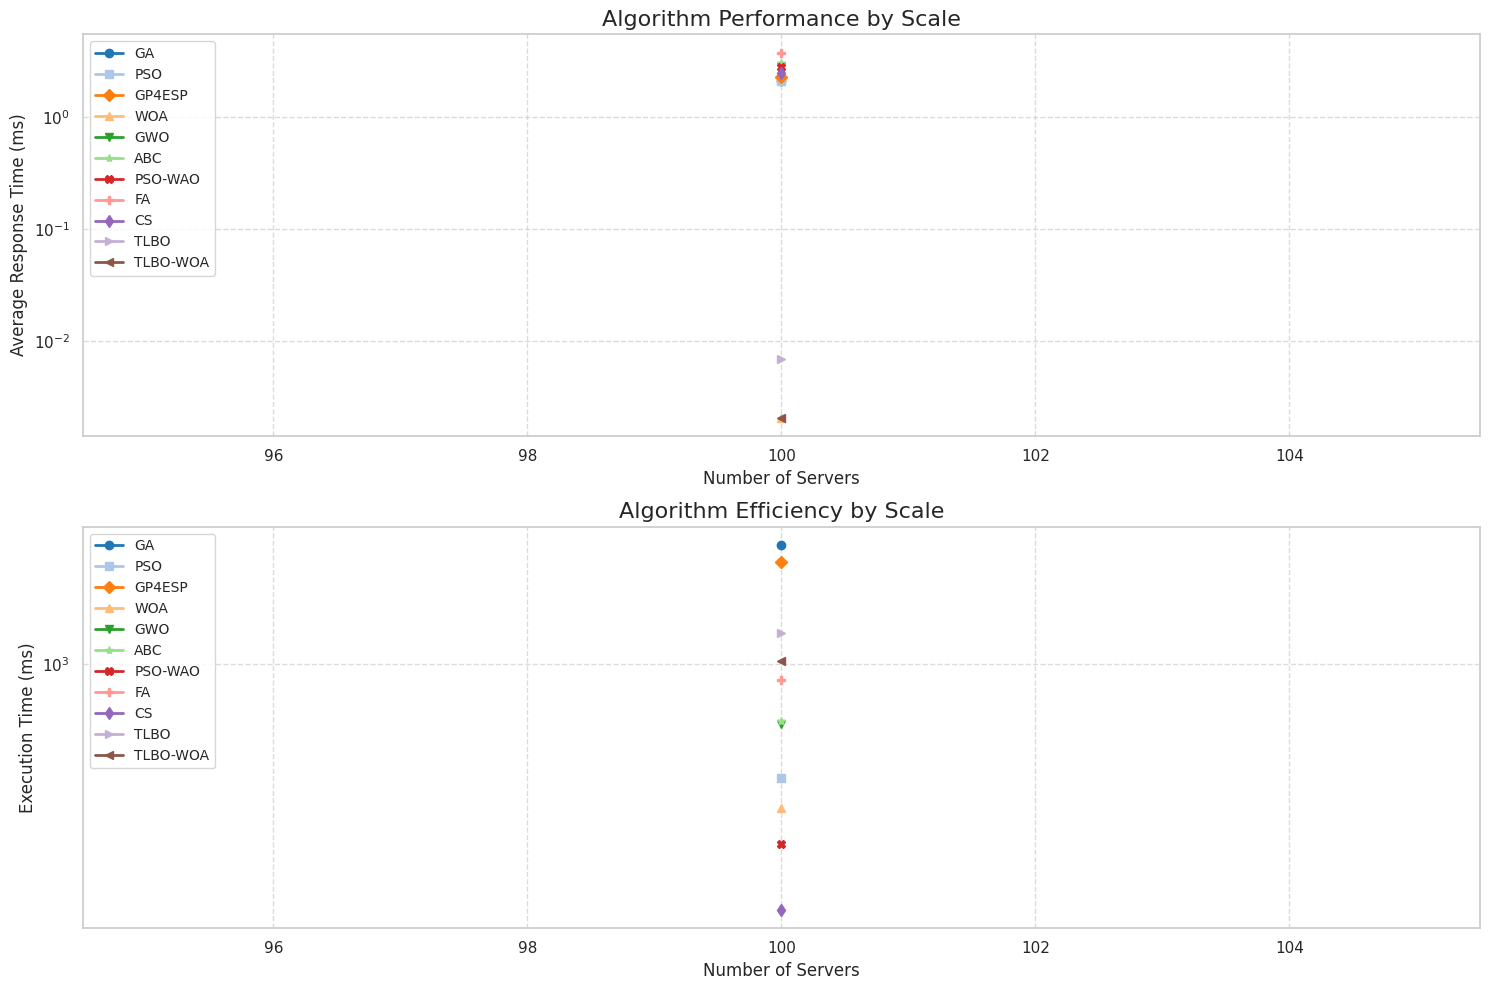


SCALE ANALYSIS SUMMARY
Algorithm    Avg Fitness (ms)     Avg Time (ms)       
------------------------------------------------------------
GA           2.098778             2469.66             
PSO          2.106938             422.30              
GP4ESP       2.289774             2173.14             
WOA          0.002089             337.75              
GWO          2.889176             638.66              
ABC          3.034624             650.42              
PSO-WAO      2.842649             256.30              
FA           3.790431             886.89              
CS           2.483049             155.63              
TLBO         0.006900             1269.04             
TLBO-WOA     0.002089             1026.75             
===== Running Load Variation Test =====

RUNNING LOAD VARIATION TEST

--- Testing Load: 10.0% ---
GA         | Response Time: 5.3909467878 ms
PSO        | Response Time: 4.0627821370 ms
GP4ESP     | Response Time: 4.4828951452 ms
WOA        | Response Tim

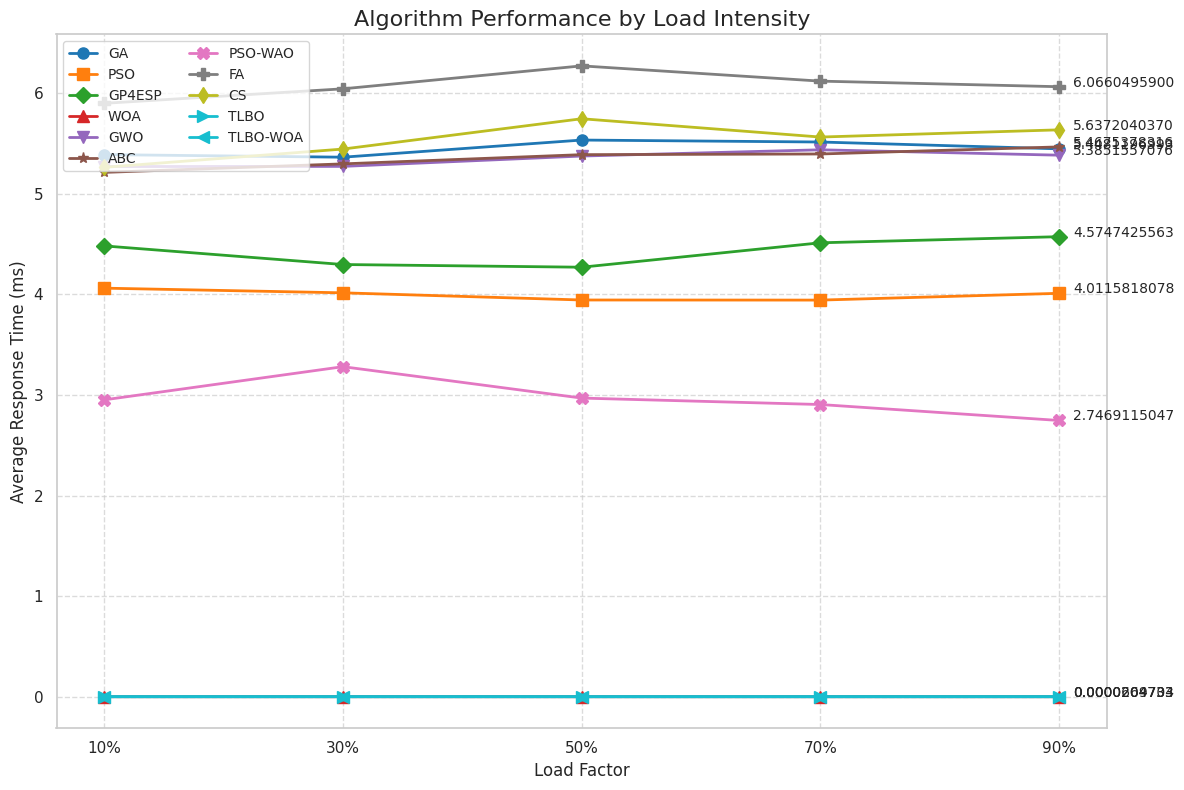


LOAD VARIATION SUMMARY
Algorithm    Avg Response (ms)   
------------------------------------------------------------
GA           5.451192            
PSO          3.995996            
GP4ESP       4.428087            
WOA          0.000014            
GWO          5.349247            
ABC          5.353568            
PSO-WAO      2.971250            
FA           6.081376            
CS           5.532142            
TLBO         0.000071            
TLBO-WOA     0.000014            
===== Running Full Experiment Suite =====
-- Load Variation Experiment --

RUNNING LOAD VARIATION TEST

--- Testing Load: 10.0% ---
GA         | Response Time: 5.5591667994 ms
PSO        | Response Time: 3.7277940544 ms
GP4ESP     | Response Time: 4.4979467652 ms
WOA        | Response Time: 0.0000134919 ms
GWO        | Response Time: 5.2506603778 ms
ABC        | Response Time: 5.1949563810 ms
PSO-WAO    | Response Time: 3.0349896214 ms
FA         | Response Time: 5.8732045062 ms
CS         | Response T

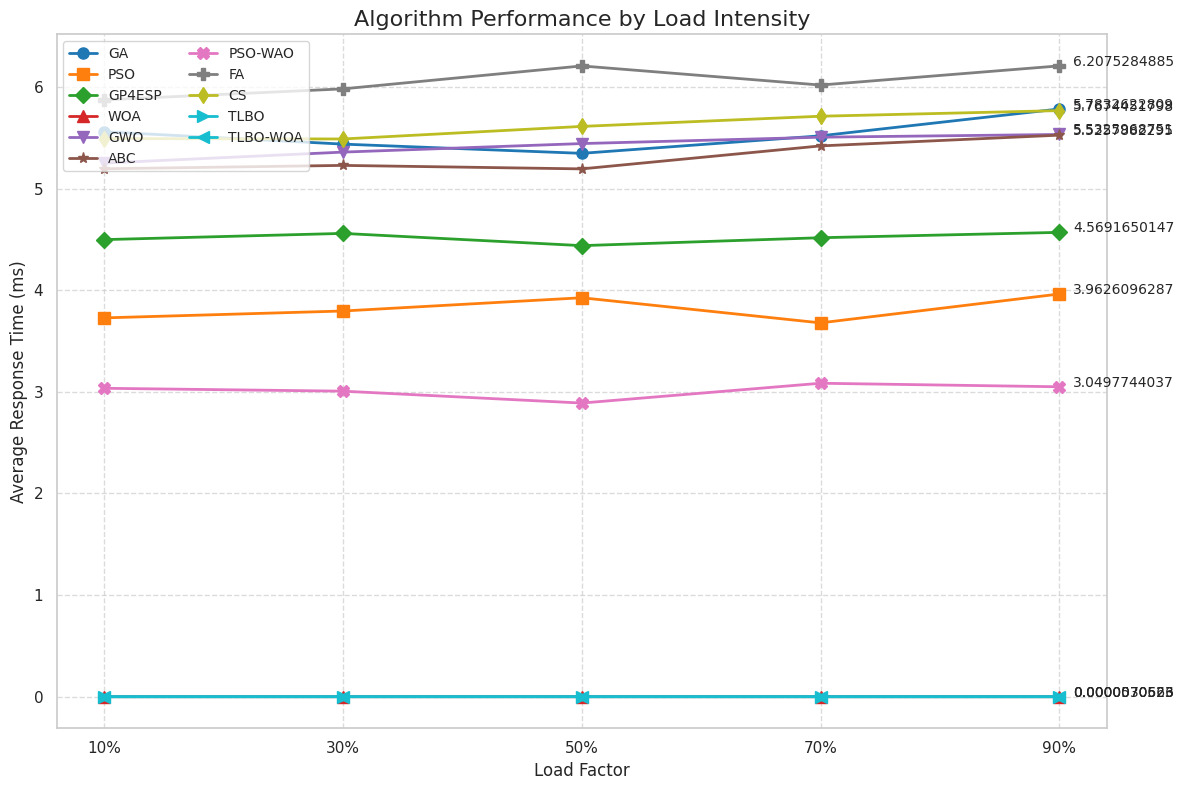


LOAD VARIATION SUMMARY
Algorithm    Avg Response (ms)   
------------------------------------------------------------
GA           5.529240            
PSO          3.818054            
GP4ESP       4.516242            
WOA          0.000014            
GWO          5.418177            
ABC          5.312551            
PSO-WAO      3.013086            
FA           6.057566            
CS           5.614325            
TLBO         0.000059            
TLBO-WOA     0.000014            
-- Scale Analysis Experiment --

===== Testing Scale: 100 servers =====
GA         | Fitness: 2.0903612407 ms | Time: 1168.05 ms
PSO        | Fitness: 2.7659055022 ms | Time: 399.55 ms
GP4ESP     | Fitness: 2.8262687224 ms | Time: 2446.32 ms
WOA        | Fitness: 0.0014542470 ms | Time: 327.50 ms
GWO        | Fitness: 3.7079901102 ms | Time: 543.96 ms
ABC        | Fitness: 3.1408126301 ms | Time: 1339.56 ms
PSO-WAO    | Fitness: 3.1512172018 ms | Time: 608.23 ms
FA         | Fitness: 4.1086646965 ms | 

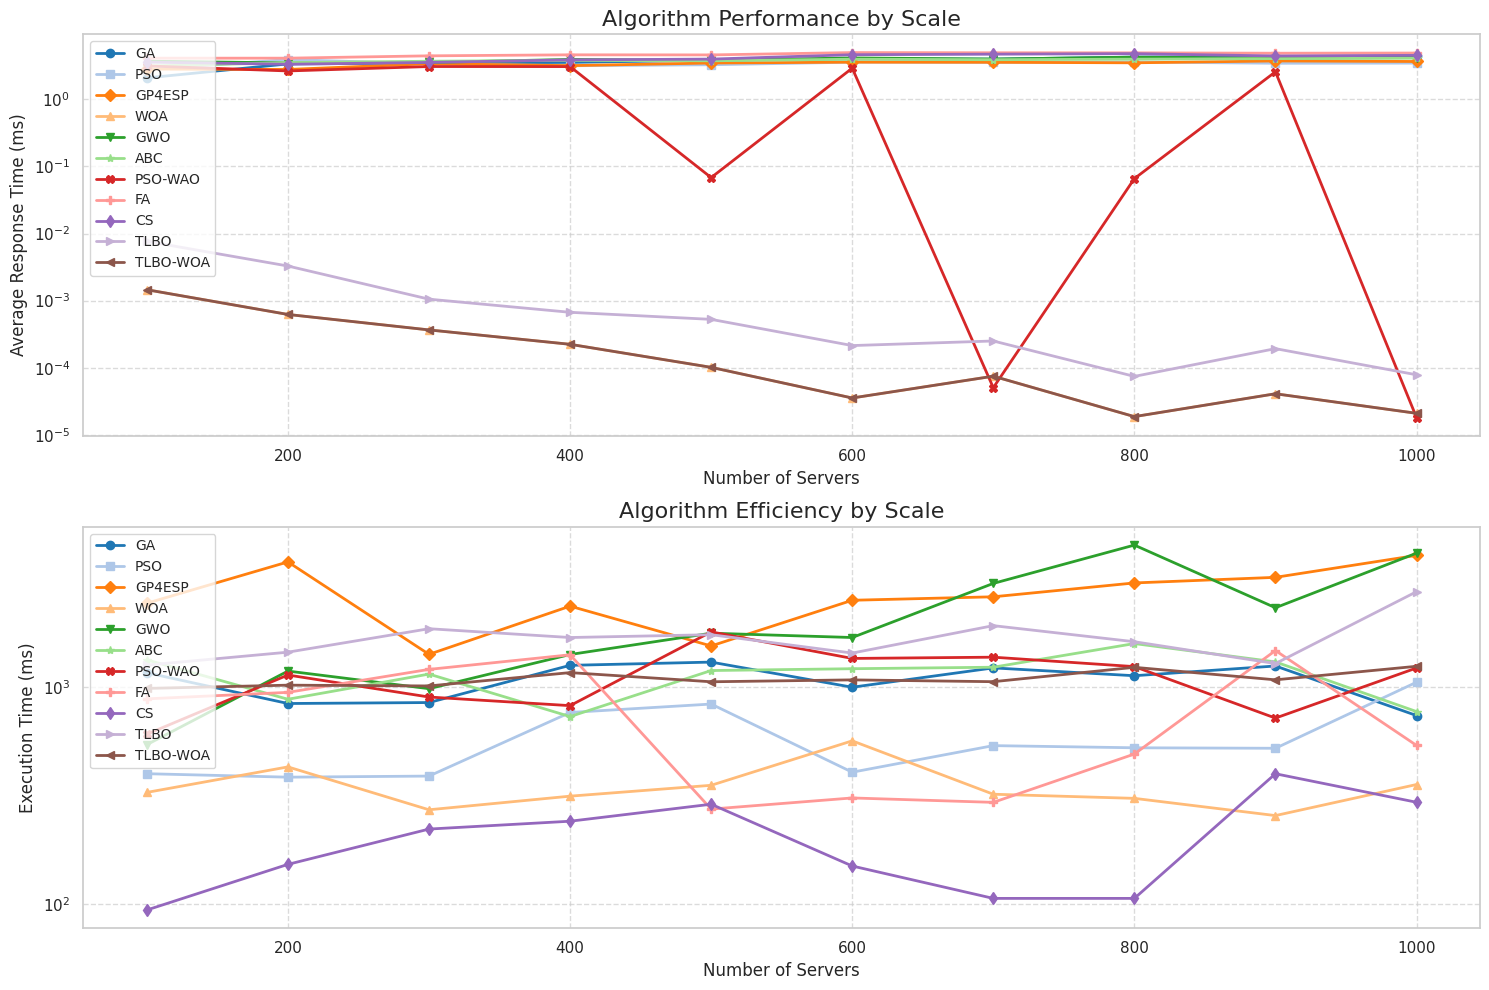


SCALE ANALYSIS SUMMARY
Algorithm    Avg Fitness (ms)     Avg Time (ms)       
------------------------------------------------------------
GA           3.736705             1079.50             
PSO          3.419608             582.85              
GP4ESP       3.375463             2705.51             
WOA          0.000296             350.47              
GWO          3.920880             2167.07             
ABC          3.792171             1143.88             
PSO-WAO      1.759485             1121.60             
FA           4.652840             784.78              
CS           4.144531             205.45              
TLBO         0.001399             1708.23             
TLBO-WOA     0.000296             1097.83             
-- Convergence Example --

RUNNING CONVERGENCE EXAMPLE
--- Running GA for convergence ---
   Final fitness: 5.4289390395 ms
--- Running PSO for convergence ---
   Final fitness: 3.9494975667 ms
--- Running GP4ESP for convergence ---
   Final fitness: 4.77

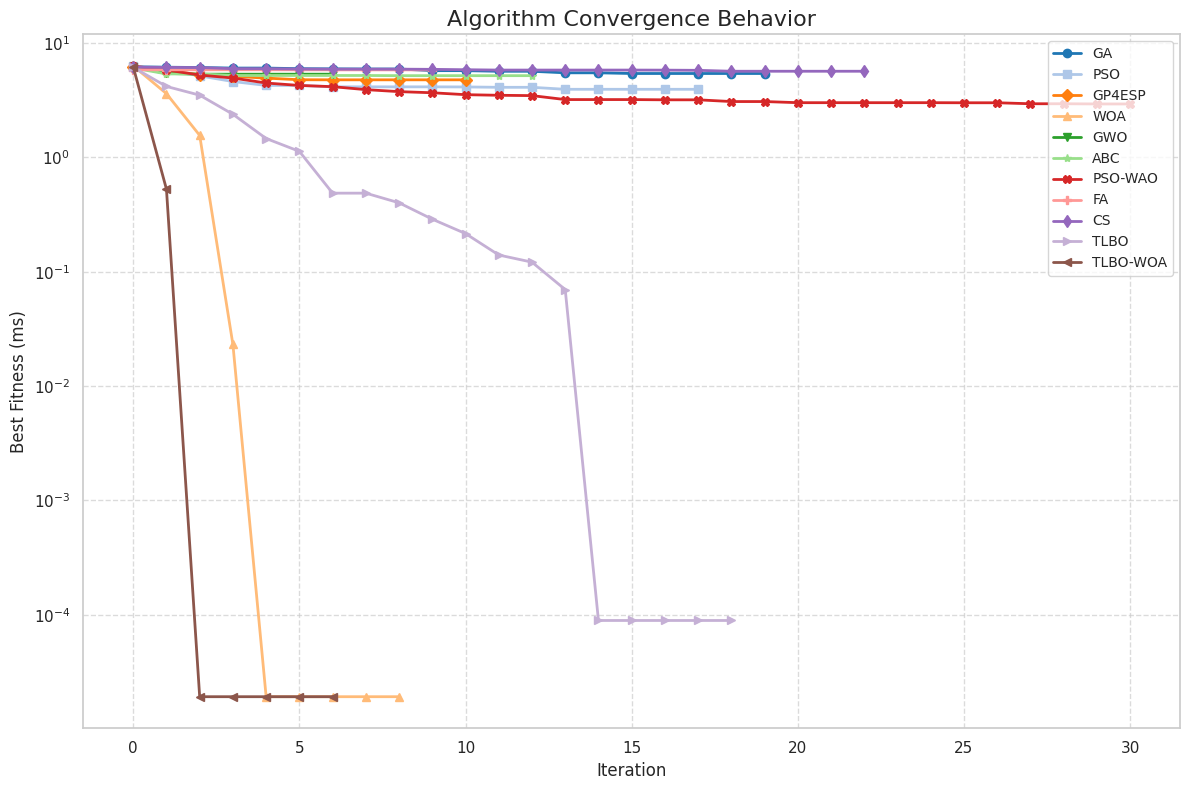

-- Statistical Analysis --

RUNNING STATISTICAL ANALYSIS (30 RUNS PER ALGORITHM)

--- GA ---
 Run 7/30: Current avg = 5.4916512464 ms
 Run 14/30: Current avg = 5.5273355153 ms
 Run 21/30: Current avg = 5.5603048970 ms
 Run 28/30: Current avg = 5.5591670929 ms

✅ GA COMPLETE | Average Response Time = 5.5457687096 ms

--- PSO ---
 Run 7/30: Current avg = 3.9952319396 ms
 Run 14/30: Current avg = 3.9779016914 ms
 Run 21/30: Current avg = 3.9790716134 ms
 Run 28/30: Current avg = 3.9876239055 ms

✅ PSO COMPLETE | Average Response Time = 3.9860358951 ms

--- GP4ESP ---
 Run 7/30: Current avg = 4.5396292880 ms
 Run 14/30: Current avg = 4.5099811872 ms
 Run 21/30: Current avg = 4.4911389247 ms
 Run 28/30: Current avg = 4.4930031258 ms

✅ GP4ESP COMPLETE | Average Response Time = 4.4793241223 ms

--- WOA ---
 Run 7/30: Current avg = 0.0000182603 ms
 Run 14/30: Current avg = 0.0000208914 ms
 Run 21/30: Current avg = 0.0000217684 ms
 Run 28/30: Current avg = 0.0000222069 ms

✅ WOA COMPLETE | Ave

<ipython-input-18-cca1cd6eca4a>:420: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results[algo] for algo in self.algorithms],
<ipython-input-18-cca1cd6eca4a>:429: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([times[algo] for algo in self.algorithms],


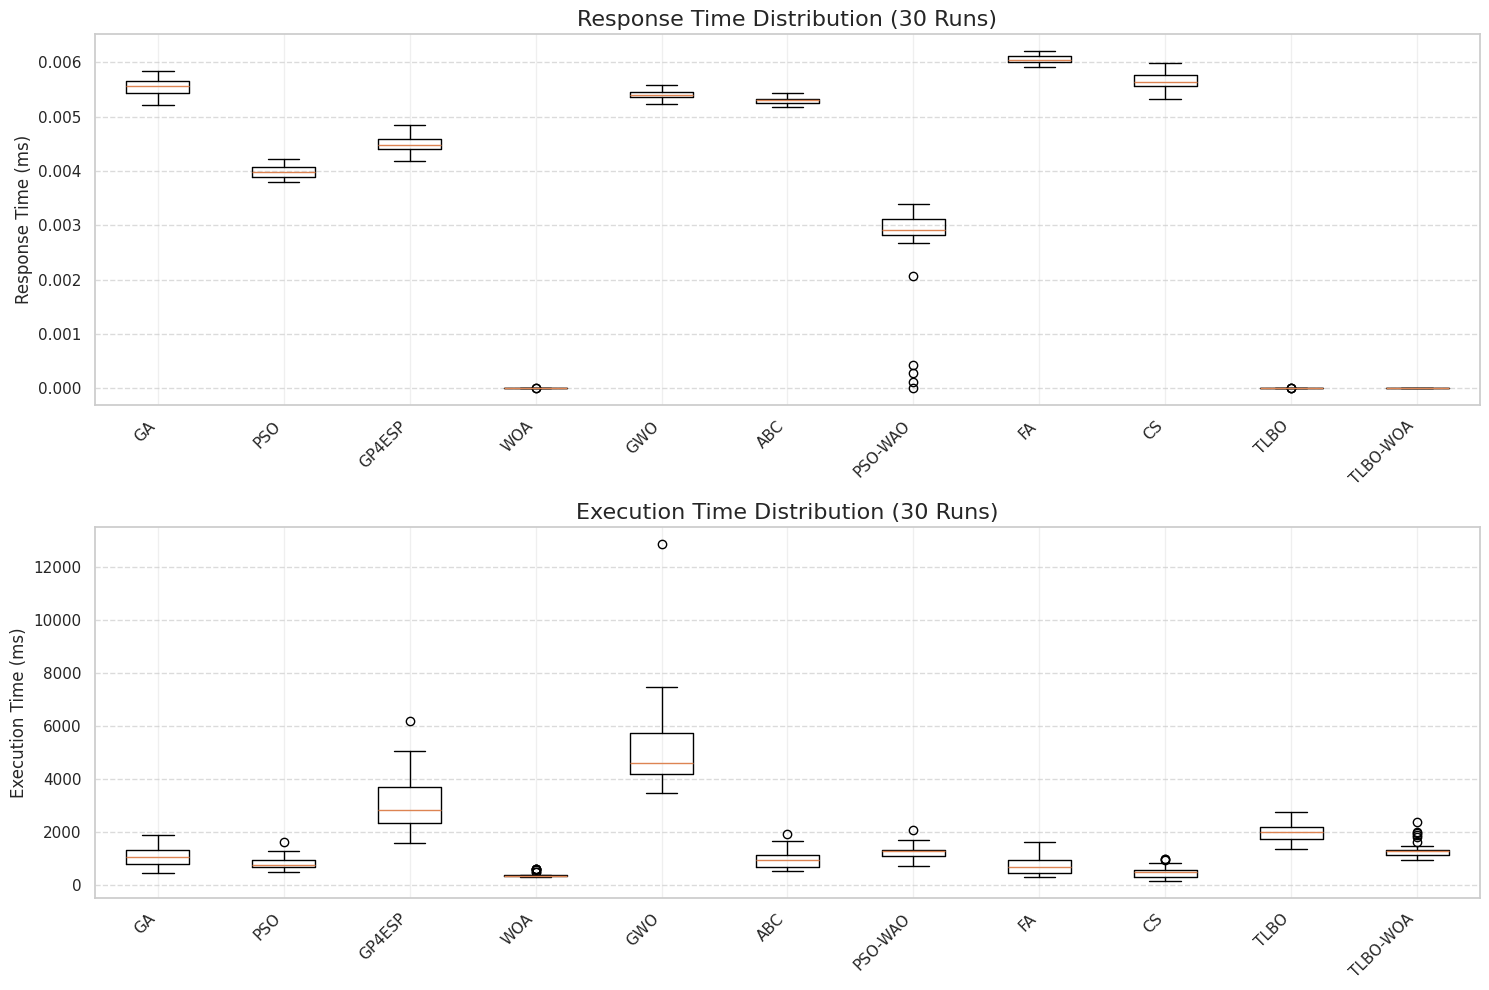


Statistical Significance (Sorted by Mean Performance):

Performance Summary:
WOA: μ = 0.0000 ms, σ = 0.0000
TLBO-WOA: μ = 0.0000 ms, σ = 0.0000
TLBO: μ = 0.0000 ms, σ = 0.0000
PSO-WAO: μ = 0.0026 ms, σ = 0.0010
PSO: μ = 0.0040 ms, σ = 0.0001
GP4ESP: μ = 0.0045 ms, σ = 0.0001
ABC: μ = 0.0053 ms, σ = 0.0001
GWO: μ = 0.0054 ms, σ = 0.0001
GA: μ = 0.0055 ms, σ = 0.0002
CS: μ = 0.0057 ms, σ = 0.0002
FA: μ = 0.0061 ms, σ = 0.0001

Pairwise t-tests:
WOA    vs TLBO-WOA: t =   -1.44 | p = 1.55×10$^{-01}$  | d = -0.38
WOA    vs TLBO: t =  -33.78 | p = 7.63×10$^{-40}$ *** | d = -8.87
WOA    vs PSO-WAO: t =  -14.46 | p = 6.75×10$^{-21}$ *** | d = -3.80
WOA    vs PSO: t = -192.28 | p = 4.68×10$^{-83}$ *** | d = -50.50
WOA    vs GP4ESP: t = -162.83 | p = 7.08×10$^{-79}$ *** | d = -42.76
WOA    vs ABC: t = -422.48 | p = 7.19×10$^{-103}$ *** | d = -110.95
WOA    vs GWO: t = -372.24 | p = 1.11×10$^{-99}$ *** | d = -97.76
WOA    vs GA: t = -189.20 | p = 1.19×10$^{-82}$ *** | d = -49.69
WOA    vs CS: t 

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
if __name__ == "__main__":
    base_config = {
        'num_bs': 1000,
        'num_srv': 900,
        'max_srv': 1000,
        'load': 0.5,
        'cloud_delay': 0.05,
        'algo_params': {
            'common': {
                'num_pop': 30,
                'dim': 900,
                'max_iter': 30
            },
            'GA': {'cross_prob': 0.8, 'mut_prob': 0.1},
            'PSO': {'w_range': (0.4, 1.2), 'c1': 2.0, 'c2': 2.0},
            'ABC': {'limit': 50},
            'FA': {'beta0': 1.0, 'gamma': 0.01, 'alpha': 0.2},
            'PSO-WAO': {},
            'CS': {'pa': 0.25, 'alpha': 0.1},
            'TLBO': {},
            'TLBO-WOA': {'b': 1.0}
        }
    }

    experimenter = PaperExperiments(base_config)

    print("===== Running Test Scale Analysis =====")
    experimenter.run_scale_analysis(scales=[100])

    print("===== Running Load Variation Test =====")
    experimenter.run_load_variation()

    print("===== Running Full Experiment Suite =====")
    print("-- Load Variation Experiment --")
    _ = experimenter.run_load_variation()

    print("-- Scale Analysis Experiment --")
    _ = experimenter.run_scale_analysis()

    print("-- Convergence Example --")
    experimenter.reset_config()
    _ = experimenter.run_convergence_example()

    print("-- Statistical Analysis --")
    _ = experimenter.run_statistical_analysis()